# Train on Depth
reference from 

https://github.com/asap-report/carla/blob/racetrack/PythonClient/racetrack/train_on_depth.py
https://github.com/ManajitPal/DeepLearningForSelfDrivingCars/blob/master/self_driving_car.py

### Imports


In [13]:
%matplotlib inline 

import torch.nn as nn
from pathlib import Path
import numpy as np 
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as Image

#### Check if data exist

In [14]:
data_dir = Path("/home/michael/Desktop/projects/ROAR/data")
# left_depth_dir = data_dir / "left"
center_depth_dir = data_dir / "center"
# right_depth_dir = data_dir / "right"
veh_state_dir = data_dir / "state"

# assert left_depth_dir.exists(), "left_depth_dir does not exist"
# assert right_depth_dir.exists(), "left_depth_dir does not exist"
assert data_dir.exists(), "data dir does not exist"
assert center_depth_dir.exists(), "left_depth_dir does not exist"
assert veh_state_dir.exists(), "veh_state_dir does not exist"

# right_depth_paths = [p for p in sorted(right_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
# left_depth_paths = [p for p in sorted(left_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
center_depth_paths = [p for p in sorted(center_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
veh_state_paths = [p for p in sorted(veh_state_dir.glob("*.npy", ), key=os.path.getmtime)]

assert len(center_depth_paths) == len(veh_state_paths),  "not the same size of X and y"
# assert len(left_depth_paths) == len(center_depth_paths)== len(right_depth_paths)==len(veh_state_paths), "not the same size of X and y"
print(f"Found { len(center_depth_paths)} data points")

Found 13689 data points


array([[<AxesSubplot:title={'center':'throttle'}>,
        <AxesSubplot:title={'center':'steering'}>]], dtype=object)

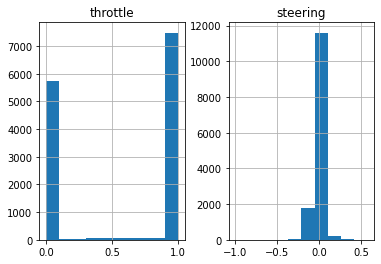

In [18]:
throttles, steerings = [], []
for st_path in veh_state_paths:
    array = np.load(st_path)
    throttles.append(array[-2])
    steerings.append(array[-1])
df = pd.DataFrame(
    data={"throttle":throttles, "steering":steerings}
)
df.hist()

### TODO: Do data augmentation

Let's only train on steering


### Define model

In [5]:
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torch

In [6]:
class Dataset(data.Dataset):

    def __init__(self, samples, left_depth_dir, center_depth_dir, right_depth_dir, state_dir, transform=None):

        self.samples = samples
        self.transform = transform
        self.left_depth_dir: Path = left_depth_dir
        self.right_depth_dir: Path = right_depth_dir
        self.center_depth_dir: Path = center_depth_dir
        self.state_dir: Path = state_dir

    def __getitem__(self, index):
      
        sample_path = self.samples[index]
        left_depth_path = self.left_depth_dir / sample_path
        center_depth_path = self.center_depth_dir / sample_path
        right_depth_path = self.right_depth_dir / sample_path
        veh_state_path = self.state_dir / sample_path
        
        left_depth = np.load(left_depth_path)
        right_depth = np.load(left_depth_path)
        center_depth = np.load(right_depth_path)
        veh_state = np.load(veh_state_path)
        
        steering_angle_center = veh_state[-1]
        steering_angle_left = steering_angle_center + 0.2
        steering_angle_right = steering_angle_center - 0.2
        return (center_depth, steering_angle_center), \
               (left_depth, steering_angle_left), \
               (right_depth, steering_angle_right)
      
    def __len__(self):
        return len(self.samples)


In [7]:
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 4}
samples = [Path(p).name for p in veh_state_paths]
samples = samples[:len(samples) - len(samples)%params['batch_size'] ]
dataset = Dataset(samples=samples, 
                  left_depth_dir = left_depth_dir, 
                  center_depth_dir=center_depth_dir, 
                  right_depth_dir=right_depth_dir,
                  state_dir = veh_state_dir)
data_generator = data.DataLoader(dataset, **params)


In [8]:
# Step6: Check the device and define function to move tensors to that device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('device is: ', device)

def toDevice(datas, device):
    imgs, angles = datas
    return imgs.float().to(device), angles.float().to(device)
def to_tensor(datas, device):
    imgs, angles = datas
    return imgs.float().to(device), angles.float().to(device)


device is:  cuda


In [9]:
class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.25),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=404736, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
        
    def forward(self, input):  
        input = input.view(input.size(0), 1, 600, 800)
        output = self.conv_layers(input)
        output = torch.flatten(output)
        output = self.linear_layers(output)
        return output
model = NvidiaModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [10]:
for epoch in range(10):
    print(f"Staring Epoch {epoch}")
    model.to(device)
    train_loss = 0
    model.train()
    counter = 0
    for i, (centers, lefts, rights) in enumerate(data_generator):
        centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
        optimizer.zero_grad()
        datas = [centers, lefts, rights]
        for data in datas:
            imgs, angles = data
            outputs = model(imgs)
            loss = criterion(outputs, angles.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.data.item()
            
        if i % 100 == 0:
            print(f"    At iteration {i} -> loss: {train_loss / (i+1)}")
    

Staring Epoch 0


/home/michael/anaconda3/envs/ROAR3.8/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


    At iteration 0 -> loss: 3.3395306151360273
    At iteration 100 -> loss: 0.20645973961288994
    At iteration 200 -> loss: 0.16451815150996546
    At iteration 300 -> loss: 0.1465253990256189
    At iteration 400 -> loss: 0.13595118645109236
    At iteration 500 -> loss: 0.12904846639479645
    At iteration 600 -> loss: 0.12515891534442267
    At iteration 700 -> loss: 0.12143148365568525
    At iteration 800 -> loss: 0.11837439401472861
    At iteration 900 -> loss: 0.11641298376155068
    At iteration 1000 -> loss: 0.11437199004777973
    At iteration 1100 -> loss: 0.11258104675857758
    At iteration 1200 -> loss: 0.11159678168689577
    At iteration 1300 -> loss: 0.11046241951947361
    At iteration 1400 -> loss: 0.1095210861216561
    At iteration 1500 -> loss: 0.10842516395194274
    At iteration 1600 -> loss: 0.10792438424600839
    At iteration 1700 -> loss: 0.10721109253450045
    At iteration 1800 -> loss: 0.10648686085190216
    At iteration 1900 -> loss: 0.1058905764515

    At iteration 2400 -> loss: 0.09392399911423528
    At iteration 2500 -> loss: 0.09376671847736022
    At iteration 2600 -> loss: 0.09410813245150204
    At iteration 2700 -> loss: 0.09401467173256274
    At iteration 2800 -> loss: 0.09399595232712159
    At iteration 2900 -> loss: 0.09382300466112778
    At iteration 3000 -> loss: 0.09374380605195547
    At iteration 3100 -> loss: 0.0937572089831344
    At iteration 3200 -> loss: 0.09369351208440219
    At iteration 3300 -> loss: 0.09378143068968173
    At iteration 3400 -> loss: 0.09383291884102316
    At iteration 3500 -> loss: 0.09385317022448258
    At iteration 3600 -> loss: 0.09379020863863655
    At iteration 3700 -> loss: 0.09393392049081212
    At iteration 3800 -> loss: 0.09395677685702399
    At iteration 3900 -> loss: 0.09391636260409716
    At iteration 4000 -> loss: 0.09403237777026488
    At iteration 4100 -> loss: 0.09414576381790393
    At iteration 4200 -> loss: 0.09406856255528423
    At iteration 4300 -> loss: 0

    At iteration 4800 -> loss: 0.09401194625010635
    At iteration 4900 -> loss: 0.09394602939075251
    At iteration 5000 -> loss: 0.09389216159266241
    At iteration 5100 -> loss: 0.09383237737135802
    At iteration 5200 -> loss: 0.09439931164496711
    At iteration 5300 -> loss: 0.09433437981035003
    At iteration 5400 -> loss: 0.0943803238498625
    At iteration 5500 -> loss: 0.0943501925631405
    At iteration 5600 -> loss: 0.09427373373952552
    At iteration 5700 -> loss: 0.09423240193488405
    At iteration 5800 -> loss: 0.09417116355873682
    At iteration 5900 -> loss: 0.0941014419612463
    At iteration 6000 -> loss: 0.09410050553730599
    At iteration 6100 -> loss: 0.0941606481117776
    At iteration 6200 -> loss: 0.09415677457513441
    At iteration 6300 -> loss: 0.0941241311442257
    At iteration 6400 -> loss: 0.09407283317698999
    At iteration 6500 -> loss: 0.09411710195517221
    At iteration 6600 -> loss: 0.09405295970536978
    At iteration 6700 -> loss: 0.094

    At iteration 7200 -> loss: 0.09371123158813657
    At iteration 7300 -> loss: 0.09370196250910544
    At iteration 7400 -> loss: 0.0936935633051126
    At iteration 7500 -> loss: 0.09365544317966232
    At iteration 7600 -> loss: 0.0936892503210347
    At iteration 7700 -> loss: 0.09368052318126036
    At iteration 7800 -> loss: 0.09366496011247477
    At iteration 7900 -> loss: 0.0936545923074178
    At iteration 8000 -> loss: 0.09362837180985764
    At iteration 8100 -> loss: 0.09362989658437375
    At iteration 8200 -> loss: 0.09360126691528467
    At iteration 8300 -> loss: 0.09358157825833482
    At iteration 8400 -> loss: 0.09357765360601573
    At iteration 8500 -> loss: 0.09357116712061941
    At iteration 8600 -> loss: 0.0935465390429126
    At iteration 8700 -> loss: 0.0935631253708343
    At iteration 8800 -> loss: 0.09354827675958309
    At iteration 8900 -> loss: 0.09352017126361097
    At iteration 9000 -> loss: 0.09364314522111906
    At iteration 9100 -> loss: 0.093

    At iteration 9600 -> loss: 0.09333613624400545
    At iteration 9700 -> loss: 0.0933194009512025
    At iteration 9800 -> loss: 0.09341233375392165
    At iteration 9900 -> loss: 0.09342677368762722
    At iteration 10000 -> loss: 0.09342078560579135
    At iteration 10100 -> loss: 0.09340312182555123
    At iteration 10200 -> loss: 0.09338090977032752
    At iteration 10300 -> loss: 0.09335139973602932
    At iteration 10400 -> loss: 0.09333599313306479
    At iteration 10500 -> loss: 0.09337434458717933
    At iteration 10600 -> loss: 0.09336153613010634
    At iteration 10700 -> loss: 0.09333771213169452
    At iteration 10800 -> loss: 0.09335134216611711
    At iteration 10900 -> loss: 0.09337228178975117
    At iteration 11000 -> loss: 0.0933450418273812
    At iteration 11100 -> loss: 0.09332998821750595
    At iteration 11200 -> loss: 0.0933347318772354
    At iteration 11300 -> loss: 0.0933143116991248
    At iteration 11400 -> loss: 0.09329614636067127
    At iteration 115

    At iteration 11900 -> loss: 0.09327033215753566
    At iteration 12000 -> loss: 0.09330776755962765
    At iteration 12100 -> loss: 0.09331787031560923
    At iteration 12200 -> loss: 0.09328010297373845
    At iteration 12300 -> loss: 0.0932642724480857
    At iteration 12400 -> loss: 0.09322379665699063
    At iteration 12500 -> loss: 0.09321200948168012
    At iteration 12600 -> loss: 0.09322824995413904
    At iteration 12700 -> loss: 0.09324992581650371
    At iteration 12800 -> loss: 0.09322116610065141
    At iteration 12900 -> loss: 0.09328141254237779
    At iteration 13000 -> loss: 0.09328401526658352
    At iteration 13100 -> loss: 0.09327217646487934
    At iteration 13200 -> loss: 0.09327924039216634
    At iteration 13300 -> loss: 0.09327741132647537
    At iteration 13400 -> loss: 0.0933012574150635
    At iteration 13500 -> loss: 0.09327355853531016
    At iteration 13600 -> loss: 0.09329171426715431
Staring Epoch 6
    At iteration 0 -> loss: 0.10213861707597971
  

    At iteration 500 -> loss: 0.0951585819418901
    At iteration 600 -> loss: 0.0944792602635033
    At iteration 700 -> loss: 0.09440664520807288
    At iteration 800 -> loss: 0.09435363032741977
    At iteration 900 -> loss: 0.09411226378910696
    At iteration 1000 -> loss: 0.09358844341355806
    At iteration 1100 -> loss: 0.09329486473351241
    At iteration 1200 -> loss: 0.0931288763764498
    At iteration 1300 -> loss: 0.09333570652600608
    At iteration 1400 -> loss: 0.0930974447830149
    At iteration 1500 -> loss: 0.09304370127034121
    At iteration 1600 -> loss: 0.09332398759236608
    At iteration 1700 -> loss: 0.0930876793461414
    At iteration 1800 -> loss: 0.09301621693079251
    At iteration 1900 -> loss: 0.09289887493493088
    At iteration 2000 -> loss: 0.09294831248972822
    At iteration 2100 -> loss: 0.09298427865840835
    At iteration 2200 -> loss: 0.09310033223988298
    At iteration 2300 -> loss: 0.09296808867361096
    At iteration 2400 -> loss: 0.09280957

    At iteration 2900 -> loss: 0.09236331625565311
    At iteration 3000 -> loss: 0.09232085729987614
    At iteration 3100 -> loss: 0.09247221608337007
    At iteration 3200 -> loss: 0.09265349698524203
    At iteration 3300 -> loss: 0.09263488213896866
    At iteration 3400 -> loss: 0.09267151951415802
    At iteration 3500 -> loss: 0.09269098288814001
    At iteration 3600 -> loss: 0.09278497728436057
    At iteration 3700 -> loss: 0.09271276109820728
    At iteration 3800 -> loss: 0.0927370062470203
    At iteration 3900 -> loss: 0.09268452356269803
    At iteration 4000 -> loss: 0.09262554338413931
    At iteration 4100 -> loss: 0.09255509497342003
    At iteration 4200 -> loss: 0.09260396369221002
    At iteration 4300 -> loss: 0.09260936225045947
    At iteration 4400 -> loss: 0.09262224876334214
    At iteration 4500 -> loss: 0.09265109824081696
    At iteration 4600 -> loss: 0.09261266080837074
    At iteration 4700 -> loss: 0.09253259852615478
    At iteration 4800 -> loss: 0

    At iteration 5300 -> loss: 0.09342251216446595
    At iteration 5400 -> loss: 0.09336816205462192
    At iteration 5500 -> loss: 0.09349196903648267
    At iteration 5600 -> loss: 0.09355535206865566
    At iteration 5700 -> loss: 0.09354212438539702
    At iteration 5800 -> loss: 0.09361172364160258
    At iteration 5900 -> loss: 0.09360824746965811
    At iteration 6000 -> loss: 0.09354059356251819
    At iteration 6100 -> loss: 0.09352251835423807
    At iteration 6200 -> loss: 0.09353115921263573
    At iteration 6300 -> loss: 0.09350606089361264
    At iteration 6400 -> loss: 0.09347218652248004
    At iteration 6500 -> loss: 0.0934393464003878
    At iteration 6600 -> loss: 0.09346687980213195
    At iteration 6700 -> loss: 0.09358859916804008
    At iteration 6800 -> loss: 0.09359950022911148
    At iteration 6900 -> loss: 0.09358370686188641
    At iteration 7000 -> loss: 0.09360263413435373
    At iteration 7100 -> loss: 0.09357704918569255
    At iteration 7200 -> loss: 0

    At iteration 7700 -> loss: 0.0937276070571275
    At iteration 7800 -> loss: 0.09369220270311912
    At iteration 7900 -> loss: 0.09368569258175036
    At iteration 8000 -> loss: 0.09368083503069183
    At iteration 8100 -> loss: 0.09368658714120906
    At iteration 8200 -> loss: 0.09369649491965604
    At iteration 8300 -> loss: 0.09368110333266423
    At iteration 8400 -> loss: 0.09364152448105938
    At iteration 8500 -> loss: 0.09359100832401554
    At iteration 8600 -> loss: 0.09356448462977077
    At iteration 8700 -> loss: 0.09353589376478975
    At iteration 8800 -> loss: 0.09355063783171856
    At iteration 8900 -> loss: 0.0935180508386212
    At iteration 9000 -> loss: 0.09353688148259208
    At iteration 9100 -> loss: 0.09348863181884301
    At iteration 9200 -> loss: 0.09347030494248816
    At iteration 9300 -> loss: 0.09352089286366246
    At iteration 9400 -> loss: 0.09357535377857217
    At iteration 9500 -> loss: 0.09358660918512259
    At iteration 9600 -> loss: 0.

    At iteration 10100 -> loss: 0.09352184717167014
    At iteration 10200 -> loss: 0.0934831771847807
    At iteration 10300 -> loss: 0.09348539232728316
    At iteration 10400 -> loss: 0.09350460473544805
    At iteration 10500 -> loss: 0.09349497168065082
    At iteration 10600 -> loss: 0.09354630528758927
    At iteration 10700 -> loss: 0.09353471978194387
    At iteration 10800 -> loss: 0.09350658147357498
    At iteration 10900 -> loss: 0.093468759409749
    At iteration 11000 -> loss: 0.09348454204590577
    At iteration 11100 -> loss: 0.09347555944545748
    At iteration 11200 -> loss: 0.0934769141820874
    At iteration 11300 -> loss: 0.0934282968654078
    At iteration 11400 -> loss: 0.09340772744354235
    At iteration 11500 -> loss: 0.09337426409669419
    At iteration 11600 -> loss: 0.0933414077814365
    At iteration 11700 -> loss: 0.09342630765316033
    At iteration 11800 -> loss: 0.09339054124479643
    At iteration 11900 -> loss: 0.09336840623667983
    At iteration 1

    At iteration 12500 -> loss: 0.09307496540351855
    At iteration 12600 -> loss: 0.09304778177431494
    At iteration 12700 -> loss: 0.09303563089913183
    At iteration 12800 -> loss: 0.09327427861556563
    At iteration 12900 -> loss: 0.0932743178787067
    At iteration 13000 -> loss: 0.09326002460679764
    At iteration 13100 -> loss: 0.09324409654460257
    At iteration 13200 -> loss: 0.0932219893634351
    At iteration 13300 -> loss: 0.09320205213920135
    At iteration 13400 -> loss: 0.09322040144459774
    At iteration 13500 -> loss: 0.09319986951795046
    At iteration 13600 -> loss: 0.09318367835831565
Staring Epoch 13
    At iteration 0 -> loss: 0.08523364516440779
    At iteration 100 -> loss: 0.08981751117061694
    At iteration 200 -> loss: 0.09011835929665303
    At iteration 300 -> loss: 0.0898673214872494
    At iteration 400 -> loss: 0.08990748805509326
    At iteration 500 -> loss: 0.09025726792262806
    At iteration 600 -> loss: 0.0904513693214831
    At iteratio

    At iteration 1200 -> loss: 0.09285844028314384
    At iteration 1300 -> loss: 0.09283779484140477
    At iteration 1400 -> loss: 0.09285575382805751
    At iteration 1500 -> loss: 0.09296992785640008
    At iteration 1600 -> loss: 0.09300334756798379
    At iteration 1700 -> loss: 0.09468986024532534
    At iteration 1800 -> loss: 0.09464555361588636
    At iteration 1900 -> loss: 0.09460355354944681
    At iteration 2000 -> loss: 0.0948416079479696
    At iteration 2100 -> loss: 0.09459546890205467
    At iteration 2200 -> loss: 0.09439087949133247
    At iteration 2300 -> loss: 0.09431202183405818
    At iteration 2400 -> loss: 0.09411914695465586
    At iteration 2500 -> loss: 0.09401544942680498
    At iteration 2600 -> loss: 0.09378457543078056
    At iteration 2700 -> loss: 0.09365624335665881
    At iteration 2800 -> loss: 0.09369674690599104
    At iteration 2900 -> loss: 0.09362109986890879
    At iteration 3000 -> loss: 0.09350932119487515
    At iteration 3100 -> loss: 0

    At iteration 3600 -> loss: 0.09337717428491736
    At iteration 3700 -> loss: 0.0932871127265962
    At iteration 3800 -> loss: 0.09322188243351294
    At iteration 3900 -> loss: 0.09337048733754698
    At iteration 4000 -> loss: 0.09327533850053978
    At iteration 4100 -> loss: 0.09326929679945657
    At iteration 4200 -> loss: 0.09319172583444513
    At iteration 4300 -> loss: 0.09319956811107617
    At iteration 4400 -> loss: 0.0931162673013359
    At iteration 4500 -> loss: 0.09305250351755874
    At iteration 4600 -> loss: 0.09307765755167928
    At iteration 4700 -> loss: 0.09301662090181206
    At iteration 4800 -> loss: 0.0929741132282559
    At iteration 4900 -> loss: 0.09300772861624768
    At iteration 5000 -> loss: 0.0929716632443095
    At iteration 5100 -> loss: 0.09294741015249085
    At iteration 5200 -> loss: 0.09291718843962443
    At iteration 5300 -> loss: 0.09291255238181917
    At iteration 5400 -> loss: 0.09286536817917893
    At iteration 5500 -> loss: 0.09

    At iteration 6000 -> loss: 0.09312455905508552
    At iteration 6100 -> loss: 0.09308984336204645
    At iteration 6200 -> loss: 0.0931856617065706
    At iteration 6300 -> loss: 0.09312094592309027
    At iteration 6400 -> loss: 0.09313690462267826
    At iteration 6500 -> loss: 0.09307116493121387
    At iteration 6600 -> loss: 0.09307030353986098
    At iteration 6700 -> loss: 0.09303958072751431
    At iteration 6800 -> loss: 0.09305520116226663
    At iteration 6900 -> loss: 0.09298548093172915
    At iteration 7000 -> loss: 0.09314402160426331
    At iteration 7100 -> loss: 0.09311817860522024
    At iteration 7200 -> loss: 0.09312182251738896
    At iteration 7300 -> loss: 0.0930973154517498
    At iteration 7400 -> loss: 0.09306518253444242
    At iteration 7500 -> loss: 0.09301712481302805
    At iteration 7600 -> loss: 0.09344270031673077
    At iteration 7700 -> loss: 0.09344093375279838
    At iteration 7800 -> loss: 0.0935031153410648
    At iteration 7900 -> loss: 0.0

    At iteration 8400 -> loss: 0.09288987697762978
    At iteration 8500 -> loss: 0.09291787655665137
    At iteration 8600 -> loss: 0.09291828837278145
    At iteration 8700 -> loss: 0.09297862739498335
    At iteration 8800 -> loss: 0.09297432903030454
    At iteration 8900 -> loss: 0.09294663126335469
    At iteration 9000 -> loss: 0.09293001248618757
    At iteration 9100 -> loss: 0.09291883969660115
    At iteration 9200 -> loss: 0.09290165775812115
    At iteration 9300 -> loss: 0.0929216732643052
    At iteration 9400 -> loss: 0.09293137301211767
    At iteration 9500 -> loss: 0.09290102539015288
    At iteration 9600 -> loss: 0.09290297708941325
    At iteration 9700 -> loss: 0.09290853871907818
    At iteration 9800 -> loss: 0.09291305920923491
    At iteration 9900 -> loss: 0.09292036642884927
    At iteration 10000 -> loss: 0.09293628115992357
    At iteration 10100 -> loss: 0.09294830798369123
    At iteration 10200 -> loss: 0.09294546294616476
    At iteration 10300 -> los

    At iteration 10800 -> loss: 0.09320234146292758
    At iteration 10900 -> loss: 0.09318388563873244
    At iteration 11000 -> loss: 0.09314569193172381
    At iteration 11100 -> loss: 0.0931276938653972
    At iteration 11200 -> loss: 0.09309568455740165
    At iteration 11300 -> loss: 0.0931898195122608
    At iteration 11400 -> loss: 0.0931707686201816
    At iteration 11500 -> loss: 0.09325139239962994
    At iteration 11600 -> loss: 0.09322310934224165
    At iteration 11700 -> loss: 0.0931812396682403
    At iteration 11800 -> loss: 0.0931839438489809
    At iteration 11900 -> loss: 0.09316376888186872
    At iteration 12000 -> loss: 0.09318739553135842
    At iteration 12100 -> loss: 0.09316349857246738
    At iteration 12200 -> loss: 0.09314789536768521
    At iteration 12300 -> loss: 0.09312513729551299
    At iteration 12400 -> loss: 0.09313659879111054
    At iteration 12500 -> loss: 0.09314214910806977
    At iteration 12600 -> loss: 0.09322011003534554
    At iteration 

    At iteration 13100 -> loss: 0.09314702790303495
    At iteration 13200 -> loss: 0.09319458919130226
    At iteration 13300 -> loss: 0.09317747106398508
    At iteration 13400 -> loss: 0.0931648580871357
    At iteration 13500 -> loss: 0.09318422659743837
    At iteration 13600 -> loss: 0.09317472073255215
Staring Epoch 20
    At iteration 0 -> loss: 0.09500360116362572
    At iteration 100 -> loss: 0.08885620691158143
    At iteration 200 -> loss: 0.0951312953907297
    At iteration 300 -> loss: 0.09505228463904783
    At iteration 400 -> loss: 0.09374505517916809
    At iteration 500 -> loss: 0.09398990292440834
    At iteration 600 -> loss: 0.09330757867938289
    At iteration 700 -> loss: 0.0928645646170637
    At iteration 800 -> loss: 0.09282510386956343
    At iteration 900 -> loss: 0.09284321978158312
    At iteration 1000 -> loss: 0.0930417838386366
    At iteration 1100 -> loss: 0.09353994643083677
    At iteration 1200 -> loss: 0.09321355424662923
    At iteration 1300 ->

    At iteration 1800 -> loss: 0.0938997321599432
    At iteration 1900 -> loss: 0.09376725026517288
    At iteration 2000 -> loss: 0.09364062589386918
    At iteration 2100 -> loss: 0.09345922370279554
    At iteration 2200 -> loss: 0.0934976055033121
    At iteration 2300 -> loss: 0.09337725285579034
    At iteration 2400 -> loss: 0.09334089841614389
    At iteration 2500 -> loss: 0.09326367777807204
    At iteration 2600 -> loss: 0.09305387863911145
    At iteration 2700 -> loss: 0.09305471852123692
    At iteration 2800 -> loss: 0.09294581676104155
    At iteration 2900 -> loss: 0.09298047565523643
    At iteration 3000 -> loss: 0.0929391606624411
    At iteration 3100 -> loss: 0.09304786727589785
    At iteration 3200 -> loss: 0.09292964239847126
    At iteration 3300 -> loss: 0.09285462778822835
    At iteration 3400 -> loss: 0.09285094137906748
    At iteration 3500 -> loss: 0.09276578116151062
    At iteration 3600 -> loss: 0.0926765307873012
    At iteration 3700 -> loss: 0.09

    At iteration 4200 -> loss: 0.09264277321811909
    At iteration 4300 -> loss: 0.09262677873453368
    At iteration 4400 -> loss: 0.09265401018949737
    At iteration 4500 -> loss: 0.09262640458014391
    At iteration 4600 -> loss: 0.09263586781560705
    At iteration 4700 -> loss: 0.092550151850859
    At iteration 4800 -> loss: 0.09265050487879767
    At iteration 4900 -> loss: 0.0926490691642175
    At iteration 5000 -> loss: 0.0926191068930282
    At iteration 5100 -> loss: 0.09315861710096825
    At iteration 5200 -> loss: 0.09314043770411891
    At iteration 5300 -> loss: 0.09310362601914177
    At iteration 5400 -> loss: 0.09305930020224544
    At iteration 5500 -> loss: 0.09316666015543913
    At iteration 5600 -> loss: 0.09319470280159253
    At iteration 5700 -> loss: 0.09317232788054217
    At iteration 5800 -> loss: 0.0931104744521794
    At iteration 5900 -> loss: 0.09304975351502943
    At iteration 6000 -> loss: 0.09307827120224355
    At iteration 6100 -> loss: 0.093

    At iteration 6600 -> loss: 0.09304748588178181
    At iteration 6700 -> loss: 0.09305127571862185
    At iteration 6800 -> loss: 0.09298339974443888
    At iteration 6900 -> loss: 0.0929393195753241
    At iteration 7000 -> loss: 0.09295897553295925
    At iteration 7100 -> loss: 0.09294455151678274
    At iteration 7200 -> loss: 0.09292103949577038
    At iteration 7300 -> loss: 0.09295283702187863
    At iteration 7400 -> loss: 0.09296282084457029
    At iteration 7500 -> loss: 0.09297319810202696
    At iteration 7600 -> loss: 0.09307353786263198
    At iteration 7700 -> loss: 0.09305637196795226
    At iteration 7800 -> loss: 0.09302539486925027
    At iteration 7900 -> loss: 0.09317234866899639
    At iteration 8000 -> loss: 0.09314331044218721
    At iteration 8100 -> loss: 0.0933087619967569
    At iteration 8200 -> loss: 0.09327808747118985
    At iteration 8300 -> loss: 0.09332877297888201
    At iteration 8400 -> loss: 0.09329200238130624
    At iteration 8500 -> loss: 0.

    At iteration 9000 -> loss: 0.09243304779359603
    At iteration 9100 -> loss: 0.09239081791372915
    At iteration 9200 -> loss: 0.09239259473794087
    At iteration 9300 -> loss: 0.09239907686751046
    At iteration 9400 -> loss: 0.09239284719647713
    At iteration 9500 -> loss: 0.09237672643192708
    At iteration 9600 -> loss: 0.09239144575917746
    At iteration 9700 -> loss: 0.09247030066661249
    At iteration 9800 -> loss: 0.0924545486844354
    At iteration 9900 -> loss: 0.09255151802510177
    At iteration 10000 -> loss: 0.09259159627928266
    At iteration 10100 -> loss: 0.09258585957055536
    At iteration 10200 -> loss: 0.09257864268546454
    At iteration 10300 -> loss: 0.09259534518562205
    At iteration 10400 -> loss: 0.0925587568687012
    At iteration 10500 -> loss: 0.09260263768782265
    At iteration 10600 -> loss: 0.09260450925396074
    At iteration 10700 -> loss: 0.09259499045698703
    At iteration 10800 -> loss: 0.09260101800822461
    At iteration 10900 -

    At iteration 11300 -> loss: 0.09282455274166905
    At iteration 11400 -> loss: 0.09280569794203439
    At iteration 11500 -> loss: 0.09279822134070989
    At iteration 11600 -> loss: 0.09314119316796036
    At iteration 11700 -> loss: 0.09315229042646953
    At iteration 11800 -> loss: 0.09313041015126897
    At iteration 11900 -> loss: 0.09318307909441774
    At iteration 12000 -> loss: 0.09317931727158545
    At iteration 12100 -> loss: 0.09315775533280028
    At iteration 12200 -> loss: 0.09316271914260411
    At iteration 12300 -> loss: 0.09319155431930466
    At iteration 12400 -> loss: 0.09317870437857749
    At iteration 12500 -> loss: 0.09316302276740254
    At iteration 12600 -> loss: 0.09319895535188881
    At iteration 12700 -> loss: 0.09321140727739047
    At iteration 12800 -> loss: 0.09318777132004608
    At iteration 12900 -> loss: 0.09316193893105251
    At iteration 13000 -> loss: 0.09316125236798874
    At iteration 13100 -> loss: 0.09316146558545933
    At itera

    At iteration 13600 -> loss: 0.0930821601325508
Staring Epoch 27
    At iteration 0 -> loss: 0.08885245420970023
    At iteration 100 -> loss: 0.0909985354362477
    At iteration 200 -> loss: 0.09252106144449204
    At iteration 300 -> loss: 0.09196401300983315
    At iteration 400 -> loss: 0.09212610890524972
    At iteration 500 -> loss: 0.09201030582160515
    At iteration 600 -> loss: 0.09273719219939361
    At iteration 700 -> loss: 0.09333757385732518
    At iteration 800 -> loss: 0.09297746788570684
    At iteration 900 -> loss: 0.09276806826648036
    At iteration 1000 -> loss: 0.09246474384440324
    At iteration 1100 -> loss: 0.09252249375183853
    At iteration 1200 -> loss: 0.09240726809145218
    At iteration 1300 -> loss: 0.09228205656626318
    At iteration 1400 -> loss: 0.09277639445556192
    At iteration 1500 -> loss: 0.09295798384153284
    At iteration 1600 -> loss: 0.09307525999208842
    At iteration 1700 -> loss: 0.09302906433376097
    At iteration 1800 -> lo

    At iteration 2300 -> loss: 0.09532179941711054
    At iteration 2400 -> loss: 0.09508537118624011
    At iteration 2500 -> loss: 0.09487733543961582
    At iteration 2600 -> loss: 0.0947768878592959
    At iteration 2700 -> loss: 0.094618388627199
    At iteration 2800 -> loss: 0.09475616448613786
    At iteration 2900 -> loss: 0.09476519968565815
    At iteration 3000 -> loss: 0.09471496950996038
    At iteration 3100 -> loss: 0.0946811134208466
    At iteration 3200 -> loss: 0.09452756066874243
    At iteration 3300 -> loss: 0.09443970571781368
    At iteration 3400 -> loss: 0.09433952030423036
    At iteration 3500 -> loss: 0.09423467172373147
    At iteration 3600 -> loss: 0.09413019411493351
    At iteration 3700 -> loss: 0.09405416512149604
    At iteration 3800 -> loss: 0.09395905072890107
    At iteration 3900 -> loss: 0.09394814079379767
    At iteration 4000 -> loss: 0.09384098853673152
    At iteration 4100 -> loss: 0.09384240868475534
    At iteration 4200 -> loss: 0.09

    At iteration 4700 -> loss: 0.09361611833687115
    At iteration 4800 -> loss: 0.09355669590701085
    At iteration 4900 -> loss: 0.09355015042928755
    At iteration 5000 -> loss: 0.09345693463115236
    At iteration 5100 -> loss: 0.09340597274195855
    At iteration 5200 -> loss: 0.09334996740820556
    At iteration 5300 -> loss: 0.09329691128745711
    At iteration 5400 -> loss: 0.09323161560304467
    At iteration 5500 -> loss: 0.09324685711557816
    At iteration 5600 -> loss: 0.09327894265529295
    At iteration 5700 -> loss: 0.09325778576141898
    At iteration 5800 -> loss: 0.0932135282960051
    At iteration 5900 -> loss: 0.09327816069450144
    At iteration 6000 -> loss: 0.09343788452651541
    At iteration 6100 -> loss: 0.09338193536889305
    At iteration 6200 -> loss: 0.09332361232738848
    At iteration 6300 -> loss: 0.09327139452740985
    At iteration 6400 -> loss: 0.09330064319092057
    At iteration 6500 -> loss: 0.09331850799761422
    At iteration 6600 -> loss: 0

    At iteration 7100 -> loss: 0.09293103741585941
    At iteration 7200 -> loss: 0.09290333896920835
    At iteration 7300 -> loss: 0.09291177930410002
    At iteration 7400 -> loss: 0.09286565374088884
    At iteration 7500 -> loss: 0.09281202671935937
    At iteration 7600 -> loss: 0.09284313225347961
    At iteration 7700 -> loss: 0.0928766440945519
    At iteration 7800 -> loss: 0.09284462040553794
    At iteration 7900 -> loss: 0.09288765046523473
    At iteration 8000 -> loss: 0.09286681843430555
    At iteration 8100 -> loss: 0.09325608294939962
    At iteration 8200 -> loss: 0.09319931557633843
    At iteration 8300 -> loss: 0.09316059665261404
    At iteration 8400 -> loss: 0.09311635365483333
    At iteration 8500 -> loss: 0.09321753733190884
    At iteration 8600 -> loss: 0.09319970194636899
    At iteration 8700 -> loss: 0.0931819161335769
    At iteration 8800 -> loss: 0.09317039638830274
    At iteration 8900 -> loss: 0.0932752348540048
    At iteration 9000 -> loss: 0.0

    At iteration 9500 -> loss: 0.09309336416475406
    At iteration 9600 -> loss: 0.0931652119693178
    At iteration 9700 -> loss: 0.09311420145094305
    At iteration 9800 -> loss: 0.09307690602055635
    At iteration 9900 -> loss: 0.09307397420945542
    At iteration 10000 -> loss: 0.0930490965319061
    At iteration 10100 -> loss: 0.09301717425276552
    At iteration 10200 -> loss: 0.09299654177324564
    At iteration 10300 -> loss: 0.09298632283202331
    At iteration 10400 -> loss: 0.09301574915024402
    At iteration 10500 -> loss: 0.09297946171543653
    At iteration 10600 -> loss: 0.09298853864974048
    At iteration 10700 -> loss: 0.09295896273644091
    At iteration 10800 -> loss: 0.09292697762960404
    At iteration 10900 -> loss: 0.09291219294458396
    At iteration 11000 -> loss: 0.0929845665378665
    At iteration 11100 -> loss: 0.09302206074635488
    At iteration 11200 -> loss: 0.09304770011427291
    At iteration 11300 -> loss: 0.09306820770612799
    At iteration 114

    At iteration 11800 -> loss: 0.09320659333516919
    At iteration 11900 -> loss: 0.0932313196880567
    At iteration 12000 -> loss: 0.09320650652833931
    At iteration 12100 -> loss: 0.09317518551879371
    At iteration 12200 -> loss: 0.09321237084378238
    At iteration 12300 -> loss: 0.09319830738299607
    At iteration 12400 -> loss: 0.09318678752548215
    At iteration 12500 -> loss: 0.09324713938004114
    At iteration 12600 -> loss: 0.09321017155054136
    At iteration 12700 -> loss: 0.09317917002842896
    At iteration 12800 -> loss: 0.09319018510804868
    At iteration 12900 -> loss: 0.09319702009614197
    At iteration 13000 -> loss: 0.09316388058959973
    At iteration 13100 -> loss: 0.09315243185920244
    At iteration 13200 -> loss: 0.09313152099952914
    At iteration 13300 -> loss: 0.09312711137056252
    At iteration 13400 -> loss: 0.09311762394935869
    At iteration 13500 -> loss: 0.09310616620546282
    At iteration 13600 -> loss: 0.09313196367129563
Staring Epoch

    At iteration 400 -> loss: 0.09290502667487409
    At iteration 500 -> loss: 0.09190859118194791
    At iteration 600 -> loss: 0.09218809083360298
    At iteration 700 -> loss: 0.09205481400264595
    At iteration 800 -> loss: 0.09211911945910134
    At iteration 900 -> loss: 0.0929608584578428
    At iteration 1000 -> loss: 0.09281449009423076
    At iteration 1100 -> loss: 0.09264842211112059
    At iteration 1200 -> loss: 0.09256059166646569
    At iteration 1300 -> loss: 0.09294917129314473
    At iteration 1400 -> loss: 0.09348714126099873
    At iteration 1500 -> loss: 0.09376653402143426
    At iteration 1600 -> loss: 0.09399041216922849
    At iteration 1700 -> loss: 0.09369096521106916
    At iteration 1800 -> loss: 0.09345982457974655
    At iteration 1900 -> loss: 0.09350464651658358
    At iteration 2000 -> loss: 0.09333137742787861
    At iteration 2100 -> loss: 0.09322597299413672
    At iteration 2200 -> loss: 0.09326756449677256
    At iteration 2300 -> loss: 0.09328

    At iteration 2800 -> loss: 0.09398084895289491
    At iteration 2900 -> loss: 0.0938731857603141
    At iteration 3000 -> loss: 0.09384288355065455
    At iteration 3100 -> loss: 0.09383086166475567
    At iteration 3200 -> loss: 0.0938787392749894
    At iteration 3300 -> loss: 0.09389009678485881
    At iteration 3400 -> loss: 0.0939257967382594
    At iteration 3500 -> loss: 0.09393750507467659
    At iteration 3600 -> loss: 0.09391004091478479
    At iteration 3700 -> loss: 0.09390055851895941
    At iteration 3800 -> loss: 0.09377402674193087
    At iteration 3900 -> loss: 0.09379752246832763
    At iteration 4000 -> loss: 0.09368412732204853
    At iteration 4100 -> loss: 0.09360217759408172
    At iteration 4200 -> loss: 0.09358808098688418
    At iteration 4300 -> loss: 0.09357040009251799
    At iteration 4400 -> loss: 0.09357586092896653
    At iteration 4500 -> loss: 0.0934914516246226
    At iteration 4600 -> loss: 0.0934135767404592
    At iteration 4700 -> loss: 0.093

    At iteration 5200 -> loss: 0.09319797923464114
    At iteration 5300 -> loss: 0.09318331855993302
    At iteration 5400 -> loss: 0.09312742288333288
    At iteration 5500 -> loss: 0.09311495410201182
    At iteration 5600 -> loss: 0.09318758484807713
    At iteration 5700 -> loss: 0.09313881182592924
    At iteration 5800 -> loss: 0.09326184349940633
    At iteration 5900 -> loss: 0.0933234038925396
    At iteration 6000 -> loss: 0.09334146048521592
    At iteration 6100 -> loss: 0.09331519370947478
    At iteration 6200 -> loss: 0.09326418123455663
    At iteration 6300 -> loss: 0.09325518393683306
    At iteration 6400 -> loss: 0.09322484458488783
    At iteration 6500 -> loss: 0.09317358197050452
    At iteration 6600 -> loss: 0.09313952717365094
    At iteration 6700 -> loss: 0.09314357279194085
    At iteration 6800 -> loss: 0.09312788487474176
    At iteration 6900 -> loss: 0.0931023979355955
    At iteration 7000 -> loss: 0.09305357152199287
    At iteration 7100 -> loss: 0.

    At iteration 7600 -> loss: 0.09343121349114795
    At iteration 7700 -> loss: 0.09337723572302849
    At iteration 7800 -> loss: 0.09337567026821103
    At iteration 7900 -> loss: 0.09337005718625702
    At iteration 8000 -> loss: 0.09333260187266636
    At iteration 8100 -> loss: 0.09331277739909896
    At iteration 8200 -> loss: 0.09328834117565486
    At iteration 8300 -> loss: 0.09325299165583424
    At iteration 8400 -> loss: 0.09327172453235354
    At iteration 8500 -> loss: 0.09327072784308157
    At iteration 8600 -> loss: 0.09324029722417121
    At iteration 8700 -> loss: 0.09327014350295765
    At iteration 8800 -> loss: 0.09323906961265085
    At iteration 8900 -> loss: 0.09320802869363684
    At iteration 9000 -> loss: 0.09320138397567787
    At iteration 9100 -> loss: 0.09316409724745411
    At iteration 9200 -> loss: 0.09316477392955
    At iteration 9300 -> loss: 0.09314800563317492
    At iteration 9400 -> loss: 0.09312330949684809
    At iteration 9500 -> loss: 0.0

    At iteration 10000 -> loss: 0.09314309293869348
    At iteration 10100 -> loss: 0.09312123273714738
    At iteration 10200 -> loss: 0.09311025321256804
    At iteration 10300 -> loss: 0.09307723931237369
    At iteration 10400 -> loss: 0.09306722852262858
    At iteration 10500 -> loss: 0.09304965260772821
    At iteration 10600 -> loss: 0.09305413549941823
    At iteration 10700 -> loss: 0.09331095461168071
    At iteration 10800 -> loss: 0.09331315223938857
    At iteration 10900 -> loss: 0.09336370968358246
    At iteration 11000 -> loss: 0.09332216436535838
    At iteration 11100 -> loss: 0.09329476205947992
    At iteration 11200 -> loss: 0.09327608522164423
    At iteration 11300 -> loss: 0.0932820566541445
    At iteration 11400 -> loss: 0.09327614633522635
    At iteration 11500 -> loss: 0.09327241459920198
    At iteration 11600 -> loss: 0.0932352307660846
    At iteration 11700 -> loss: 0.09325751372804689
    At iteration 11800 -> loss: 0.09323462814860332
    At iterati

    At iteration 12300 -> loss: 0.0931639173835234
    At iteration 12400 -> loss: 0.09317784743011848
    At iteration 12500 -> loss: 0.09316892897125105
    At iteration 12600 -> loss: 0.09324348110298245
    At iteration 12700 -> loss: 0.0932116036305703
    At iteration 12800 -> loss: 0.09322501893336214
    At iteration 12900 -> loss: 0.09320254031890945
    At iteration 13000 -> loss: 0.09320056255992838
    At iteration 13100 -> loss: 0.09320263927924383
    At iteration 13200 -> loss: 0.09317942807102213
    At iteration 13300 -> loss: 0.0931559868227074
    At iteration 13400 -> loss: 0.09313548856865432
    At iteration 13500 -> loss: 0.09312494330276919
    At iteration 13600 -> loss: 0.09311826608221922
Staring Epoch 40
    At iteration 0 -> loss: 0.08734395424835384
    At iteration 100 -> loss: 0.09697349865644576
    At iteration 200 -> loss: 0.09427307560233272
    At iteration 300 -> loss: 0.09416213021281288
    At iteration 400 -> loss: 0.09352857837745107
    At ite

    At iteration 900 -> loss: 0.09319358993525545
    At iteration 1000 -> loss: 0.09318861272177167
    At iteration 1100 -> loss: 0.09296599871636226
    At iteration 1200 -> loss: 0.09269087395789816
    At iteration 1300 -> loss: 0.09279232112998277
    At iteration 1400 -> loss: 0.09275852281685755
    At iteration 1500 -> loss: 0.09273208589627581
    At iteration 1600 -> loss: 0.09244929194785827
    At iteration 1700 -> loss: 0.092478629055268
    At iteration 1800 -> loss: 0.09244753853963485
    At iteration 1900 -> loss: 0.09234692603919345
    At iteration 2000 -> loss: 0.09226140222276455
    At iteration 2100 -> loss: 0.09211085962861619
    At iteration 2200 -> loss: 0.09205729104969224
    At iteration 2300 -> loss: 0.09205082664020342
    At iteration 2400 -> loss: 0.09198259539714816
    At iteration 2500 -> loss: 0.09189535656504956
    At iteration 2600 -> loss: 0.09197735621825397
    At iteration 2700 -> loss: 0.09188327886501667
    At iteration 2800 -> loss: 0.0

    At iteration 3300 -> loss: 0.09318922931213802
    At iteration 3400 -> loss: 0.0931581247984931
    At iteration 3500 -> loss: 0.0932702816864049
    At iteration 3600 -> loss: 0.09315671223540516
    At iteration 3700 -> loss: 0.09309589604631363
    At iteration 3800 -> loss: 0.09330484624561373
    At iteration 3900 -> loss: 0.09327839715416976
    At iteration 4000 -> loss: 0.09339171705242362
    At iteration 4100 -> loss: 0.09335572762714824
    At iteration 4200 -> loss: 0.09327042019214894
    At iteration 4300 -> loss: 0.0931943296972783
    At iteration 4400 -> loss: 0.09315266827990432
    At iteration 4500 -> loss: 0.09384444087097536
    At iteration 4600 -> loss: 0.09381078549144752
    At iteration 4700 -> loss: 0.09373428889200772
    At iteration 4800 -> loss: 0.09373650783036494
    At iteration 4900 -> loss: 0.09369078358553108
    At iteration 5000 -> loss: 0.09377566127387203
    At iteration 5100 -> loss: 0.09371540310323617
    At iteration 5200 -> loss: 0.0

    At iteration 5700 -> loss: 0.09322248123017653
    At iteration 5800 -> loss: 0.09318925022972258
    At iteration 5900 -> loss: 0.09316487649581506
    At iteration 6000 -> loss: 0.09322418990497522
    At iteration 6100 -> loss: 0.09320749293937704
    At iteration 6200 -> loss: 0.09320839805508493
    At iteration 6300 -> loss: 0.09320146324881634
    At iteration 6400 -> loss: 0.09317393205914269
    At iteration 6500 -> loss: 0.09314251278887681
    At iteration 6600 -> loss: 0.09307813673980427
    At iteration 6700 -> loss: 0.09307384306408853
    At iteration 6800 -> loss: 0.09306700501872886
    At iteration 6900 -> loss: 0.09347869287634969
    At iteration 7000 -> loss: 0.09347688407115771
    At iteration 7100 -> loss: 0.09346444066481582
    At iteration 7200 -> loss: 0.0933917302544946
    At iteration 7300 -> loss: 0.0934110286871257
    At iteration 7400 -> loss: 0.09339441024301402
    At iteration 7500 -> loss: 0.09334576177681858
    At iteration 7600 -> loss: 0.

    At iteration 8100 -> loss: 0.09262536110757498
    At iteration 8200 -> loss: 0.09258798726119469
    At iteration 8300 -> loss: 0.09254528864309255
    At iteration 8400 -> loss: 0.09262308243624608
    At iteration 8500 -> loss: 0.09264480311909702
    At iteration 8600 -> loss: 0.09266980090976672
    At iteration 8700 -> loss: 0.09277229477804291
    At iteration 8800 -> loss: 0.092838308076229
    At iteration 8900 -> loss: 0.0928600097689051
    At iteration 9000 -> loss: 0.09283525671818606
    At iteration 9100 -> loss: 0.09281208829148871
    At iteration 9200 -> loss: 0.09282509588613733
    At iteration 9300 -> loss: 0.0928683536767656
    At iteration 9400 -> loss: 0.09286414203716449
    At iteration 9500 -> loss: 0.09287156390627087
    At iteration 9600 -> loss: 0.09287409749547541
    At iteration 9700 -> loss: 0.09287221243901764
    At iteration 9800 -> loss: 0.0928521261995942
    At iteration 9900 -> loss: 0.09283536053040972
    At iteration 10000 -> loss: 0.09

    At iteration 10500 -> loss: 0.0929944019712193
    At iteration 10600 -> loss: 0.09297001715238533
    At iteration 10700 -> loss: 0.09294539035485644
    At iteration 10800 -> loss: 0.09292641456077498
    At iteration 10900 -> loss: 0.09296198076316645
    At iteration 11000 -> loss: 0.09297028922693765
    At iteration 11100 -> loss: 0.09300875545572111
    At iteration 11200 -> loss: 0.0929993977930844
    At iteration 11300 -> loss: 0.09296314491051831
    At iteration 11400 -> loss: 0.09299995745749151
    At iteration 11500 -> loss: 0.09305750676872791
    At iteration 11600 -> loss: 0.09314621309104283
    At iteration 11700 -> loss: 0.0931765931988163
    At iteration 11800 -> loss: 0.09315457723043748
    At iteration 11900 -> loss: 0.0931237504111782
    At iteration 12000 -> loss: 0.09312756886681474
    At iteration 12100 -> loss: 0.09311999257832021
    At iteration 12200 -> loss: 0.0930854985180249
    At iteration 12300 -> loss: 0.09312303980203365
    At iteration 

    At iteration 12800 -> loss: 0.09319995979280149
    At iteration 12900 -> loss: 0.09322905381151206
    At iteration 13000 -> loss: 0.09322635399274058
    At iteration 13100 -> loss: 0.09320253982036336
    At iteration 13200 -> loss: 0.09319111897263652
    At iteration 13300 -> loss: 0.09315798919197743
    At iteration 13400 -> loss: 0.09313404478952356
    At iteration 13500 -> loss: 0.09312041423662099
    At iteration 13600 -> loss: 0.0930986613378563
Staring Epoch 47
    At iteration 0 -> loss: 0.08565998892299831
    At iteration 100 -> loss: 0.09144706657708192
    At iteration 200 -> loss: 0.09096682063724482
    At iteration 300 -> loss: 0.09087407510125525
    At iteration 400 -> loss: 0.09031288206322997
    At iteration 500 -> loss: 0.09054619884692428
    At iteration 600 -> loss: 0.09134528768164028
    At iteration 700 -> loss: 0.09132055441802332
    At iteration 800 -> loss: 0.09183646566655951
    At iteration 900 -> loss: 0.092405715238046
    At iteration 100

    At iteration 1400 -> loss: 0.09294981933365747
    At iteration 1500 -> loss: 0.09307273964101315
    At iteration 1600 -> loss: 0.09297370797581889
    At iteration 1700 -> loss: 0.09311652868380652
    At iteration 1800 -> loss: 0.0929416167775302
    At iteration 1900 -> loss: 0.09307935376926289
    At iteration 2000 -> loss: 0.092883272237567
    At iteration 2100 -> loss: 0.09284555412531623
    At iteration 2200 -> loss: 0.09273588191857378
    At iteration 2300 -> loss: 0.09285001042689825
    At iteration 2400 -> loss: 0.09426500496458683
    At iteration 2500 -> loss: 0.0941412760330035
    At iteration 2600 -> loss: 0.09397768692811688
    At iteration 2700 -> loss: 0.09385945150380944
    At iteration 2800 -> loss: 0.0938187717945127
    At iteration 2900 -> loss: 0.09380602247528426
    At iteration 3000 -> loss: 0.09371759492790974
    At iteration 3100 -> loss: 0.0936532203935104
    At iteration 3200 -> loss: 0.09361243262226102
    At iteration 3300 -> loss: 0.0937

    At iteration 3800 -> loss: 0.093313688698548
    At iteration 3900 -> loss: 0.09340530478298019
    At iteration 4000 -> loss: 0.09337531623217453
    At iteration 4100 -> loss: 0.09340998413707584
    At iteration 4200 -> loss: 0.09341545635753203
    At iteration 4300 -> loss: 0.09343058359651776
    At iteration 4400 -> loss: 0.09345286880144205
    At iteration 4500 -> loss: 0.093574196008316
    At iteration 4600 -> loss: 0.09346670947500742
    At iteration 4700 -> loss: 0.09343611615109612
    At iteration 4800 -> loss: 0.09342376547820933
    At iteration 4900 -> loss: 0.09343929038052703
    At iteration 5000 -> loss: 0.09336882262838467
    At iteration 5100 -> loss: 0.09335424492909562
    At iteration 5200 -> loss: 0.09330218455408572
    At iteration 5300 -> loss: 0.09323102190738837
    At iteration 5400 -> loss: 0.0931626338631646
    At iteration 5500 -> loss: 0.09315980480570292
    At iteration 5600 -> loss: 0.09315800967442266
    At iteration 5700 -> loss: 0.093

    At iteration 6200 -> loss: 0.09287202580115397
    At iteration 6300 -> loss: 0.09292724937272538
    At iteration 6400 -> loss: 0.09310310564075316
    At iteration 6500 -> loss: 0.09319217816247057
    At iteration 6600 -> loss: 0.09315759026006451
    At iteration 6700 -> loss: 0.09309990231636206
    At iteration 6800 -> loss: 0.09309470336965384
    At iteration 6900 -> loss: 0.09319454602070341
    At iteration 7000 -> loss: 0.09321879057463747
    At iteration 7100 -> loss: 0.0931943882974391
    At iteration 7200 -> loss: 0.09320190627402257
    At iteration 7300 -> loss: 0.09315132655058192
    At iteration 7400 -> loss: 0.09315931292015976
    At iteration 7500 -> loss: 0.09312732909058549
    At iteration 7600 -> loss: 0.09307919122024254
    At iteration 7700 -> loss: 0.09307767033018181
    At iteration 7800 -> loss: 0.09305267761000469
    At iteration 7900 -> loss: 0.09304637754426114
    At iteration 8000 -> loss: 0.0931847290066182
    At iteration 8100 -> loss: 0.

    At iteration 8600 -> loss: 0.09288001116898564
    At iteration 8700 -> loss: 0.09286738239732316
    At iteration 8800 -> loss: 0.09283913889027476
    At iteration 8900 -> loss: 0.09283395185440185
    At iteration 9000 -> loss: 0.09280741692438538
    At iteration 9100 -> loss: 0.09278593700618853
    At iteration 9200 -> loss: 0.09275451432872871
    At iteration 9300 -> loss: 0.09275050575456763
    At iteration 9400 -> loss: 0.09278936602735888
    At iteration 9500 -> loss: 0.0928614489079187
    At iteration 9600 -> loss: 0.09287583499532642
    At iteration 9700 -> loss: 0.0928665176023477
    At iteration 9800 -> loss: 0.09285539097703552
    At iteration 9900 -> loss: 0.09282438841758588
    At iteration 10000 -> loss: 0.09286110620820358
    At iteration 10100 -> loss: 0.09281851303970384
    At iteration 10200 -> loss: 0.09280824026420038
    At iteration 10300 -> loss: 0.09284491338853297
    At iteration 10400 -> loss: 0.09282338609836589
    At iteration 10500 -> lo

    At iteration 11000 -> loss: 0.0925291558827715
    At iteration 11100 -> loss: 0.09254139479391572
    At iteration 11200 -> loss: 0.09250693832010191
    At iteration 11300 -> loss: 0.09277307037653229
    At iteration 11400 -> loss: 0.0927582961460997
    At iteration 11500 -> loss: 0.09274493451864038
    At iteration 11600 -> loss: 0.0927314208625991
    At iteration 11700 -> loss: 0.09269157407417536
    At iteration 11800 -> loss: 0.09267554696525367
    At iteration 11900 -> loss: 0.09275890252231034
    At iteration 12000 -> loss: 0.09279913856493277
    At iteration 12100 -> loss: 0.09283441051209886
    At iteration 12200 -> loss: 0.0927992541973608
    At iteration 12300 -> loss: 0.09278415850318075
    At iteration 12400 -> loss: 0.09277415879733157
    At iteration 12500 -> loss: 0.09281909049926798
    At iteration 12600 -> loss: 0.09281103012591639
    At iteration 12700 -> loss: 0.09278571754888151
    At iteration 12800 -> loss: 0.09277538878483141
    At iteration

    At iteration 13300 -> loss: 0.09296515733846251
    At iteration 13400 -> loss: 0.0929407489873948
    At iteration 13500 -> loss: 0.09291575550977815
    At iteration 13600 -> loss: 0.09296596278319556
Staring Epoch 54
    At iteration 0 -> loss: 0.09291125927120447
    At iteration 100 -> loss: 0.08991598576412012
    At iteration 200 -> loss: 0.0906826043777398
    At iteration 300 -> loss: 0.09183725307628596
    At iteration 400 -> loss: 0.09134378785402887
    At iteration 500 -> loss: 0.09144589585381212
    At iteration 600 -> loss: 0.09143176811402469
    At iteration 700 -> loss: 0.09141052186810167
    At iteration 800 -> loss: 0.09115341067870511
    At iteration 900 -> loss: 0.09121740431697813
    At iteration 1000 -> loss: 0.09143814814991227
    At iteration 1100 -> loss: 0.09193257499171528
    At iteration 1200 -> loss: 0.09182979165150228
    At iteration 1300 -> loss: 0.09178232656652813
    At iteration 1400 -> loss: 0.09239917538184313
    At iteration 1500 ->

    At iteration 2000 -> loss: 0.09258759444053821
    At iteration 2100 -> loss: 0.0928479140222799
    At iteration 2200 -> loss: 0.09280805585470209
    At iteration 2300 -> loss: 0.09263162159873913
    At iteration 2400 -> loss: 0.09255652788791621
    At iteration 2500 -> loss: 0.09253239352485482
    At iteration 2600 -> loss: 0.09242515393178927
    At iteration 2700 -> loss: 0.09243588791943817
    At iteration 2800 -> loss: 0.09241397884542377
    At iteration 2900 -> loss: 0.09237489982651824
    At iteration 3000 -> loss: 0.09232259157684462
    At iteration 3100 -> loss: 0.09225913834204472
    At iteration 3200 -> loss: 0.09216490990881004
    At iteration 3300 -> loss: 0.09225503353327895
    At iteration 3400 -> loss: 0.09228869018314212
    At iteration 3500 -> loss: 0.09227791438598633
    At iteration 3600 -> loss: 0.09216638673735163
    At iteration 3700 -> loss: 0.09243258988870211
    At iteration 3800 -> loss: 0.09254957120751434
    At iteration 3900 -> loss: 0

    At iteration 4400 -> loss: 0.09254505295351062
    At iteration 4500 -> loss: 0.09256247170014195
    At iteration 4600 -> loss: 0.09256724160406808
    At iteration 4700 -> loss: 0.09263923870085011
    At iteration 4800 -> loss: 0.09266778488023705
    At iteration 4900 -> loss: 0.09273249703095848
    At iteration 5000 -> loss: 0.09271532767270645
    At iteration 5100 -> loss: 0.09278036462536897
    At iteration 5200 -> loss: 0.09271959775960306
    At iteration 5300 -> loss: 0.09268236211710047
    At iteration 5400 -> loss: 0.09264075754058247
    At iteration 5500 -> loss: 0.09255476100026779
    At iteration 5600 -> loss: 0.09251311114775418
    At iteration 5700 -> loss: 0.09251220634909235
    At iteration 5800 -> loss: 0.09247479105203792
    At iteration 5900 -> loss: 0.09246044449130461
    At iteration 6000 -> loss: 0.09244277567980284
    At iteration 6100 -> loss: 0.09253716142855839
    At iteration 6200 -> loss: 0.09249241240735213
    At iteration 6300 -> loss: 

    At iteration 6800 -> loss: 0.09314390351673336
    At iteration 6900 -> loss: 0.09317070818648704
    At iteration 7000 -> loss: 0.09314222874698368
    At iteration 7100 -> loss: 0.09310077114965427
    At iteration 7200 -> loss: 0.09307037224673817
    At iteration 7300 -> loss: 0.09302380179361236
    At iteration 7400 -> loss: 0.09303749730370844
    At iteration 7500 -> loss: 0.09298174219773601
    At iteration 7600 -> loss: 0.09297907124249351
    At iteration 7700 -> loss: 0.09300272186457363
    At iteration 7800 -> loss: 0.09303100248648388
    At iteration 7900 -> loss: 0.09303029327358384
    At iteration 8000 -> loss: 0.09302494854391628
    At iteration 8100 -> loss: 0.09295037629551774
    At iteration 8200 -> loss: 0.092928982160062
    At iteration 8300 -> loss: 0.09291007257909402
    At iteration 8400 -> loss: 0.09287841087430583
    At iteration 8500 -> loss: 0.09283703903058514
    At iteration 8600 -> loss: 0.09281457370154753
    At iteration 8700 -> loss: 0.

    At iteration 9200 -> loss: 0.09307273218751588
    At iteration 9300 -> loss: 0.09305951423191518
    At iteration 9400 -> loss: 0.09305652874978156
    At iteration 9500 -> loss: 0.09304353628583723
    At iteration 9600 -> loss: 0.09302163031916906
    At iteration 9700 -> loss: 0.09300830854710465
    At iteration 9800 -> loss: 0.0929913393250388
    At iteration 9900 -> loss: 0.09298972271046779
    At iteration 10000 -> loss: 0.09299546884926542
    At iteration 10100 -> loss: 0.09296073324814184
    At iteration 10200 -> loss: 0.09297673129000718
    At iteration 10300 -> loss: 0.09297425242178768
    At iteration 10400 -> loss: 0.09294955646075434
    At iteration 10500 -> loss: 0.09293203366671776
    At iteration 10600 -> loss: 0.09291616482038949
    At iteration 10700 -> loss: 0.09288503998602485
    At iteration 10800 -> loss: 0.09286794361322472
    At iteration 10900 -> loss: 0.09283286526191191
    At iteration 11000 -> loss: 0.09290083572186501
    At iteration 1110

    At iteration 11600 -> loss: 0.09318108924514003
    At iteration 11700 -> loss: 0.09314994333295534
    At iteration 11800 -> loss: 0.09311191474849341
    At iteration 11900 -> loss: 0.09313599595346903
    At iteration 12000 -> loss: 0.09310998355657182
    At iteration 12100 -> loss: 0.09308259788465141
    At iteration 12200 -> loss: 0.09305563212074247
    At iteration 12300 -> loss: 0.09306596947210777
    At iteration 12400 -> loss: 0.09309527256127939
    At iteration 12500 -> loss: 0.09310614157711795
    At iteration 12600 -> loss: 0.0930984025909941
    At iteration 12700 -> loss: 0.09310123415675674
    At iteration 12800 -> loss: 0.09306918557656567
    At iteration 12900 -> loss: 0.09309940210125957
    At iteration 13000 -> loss: 0.09308137536004328
    At iteration 13100 -> loss: 0.09306979909912418
    At iteration 13200 -> loss: 0.09305487370799392
    At iteration 13300 -> loss: 0.09302429940630201
    At iteration 13400 -> loss: 0.09300162353150636
    At iterat

    At iteration 200 -> loss: 0.09113571937450912
    At iteration 300 -> loss: 0.09089527770130532
    At iteration 400 -> loss: 0.09253523609910545
    At iteration 500 -> loss: 0.09299111252895749
    At iteration 600 -> loss: 0.09290564011135016
    At iteration 700 -> loss: 0.0925530769130506
    At iteration 800 -> loss: 0.09223029857063786
    At iteration 900 -> loss: 0.09226989276180879
    At iteration 1000 -> loss: 0.09515576181007734
    At iteration 1100 -> loss: 0.09458644372434044
    At iteration 1200 -> loss: 0.09448266961398699
    At iteration 1300 -> loss: 0.09456619155797406
    At iteration 1400 -> loss: 0.0943446036560857
    At iteration 1500 -> loss: 0.09445782628696087
    At iteration 1600 -> loss: 0.09424127683196466
    At iteration 1700 -> loss: 0.09409396765750794
    At iteration 1800 -> loss: 0.09403603285460604
    At iteration 1900 -> loss: 0.09384329835921426
    At iteration 2000 -> loss: 0.09368084866231885
    At iteration 2100 -> loss: 0.09345697

    At iteration 2600 -> loss: 0.09266022289507117
    At iteration 2700 -> loss: 0.09302492466457947
    At iteration 2800 -> loss: 0.09290513602515922
    At iteration 2900 -> loss: 0.09295691073757695
    At iteration 3000 -> loss: 0.09285651645109375
    At iteration 3100 -> loss: 0.09273725694365276
    At iteration 3200 -> loss: 0.0927546364225143
    At iteration 3300 -> loss: 0.0926687820097367
    At iteration 3400 -> loss: 0.09257280421452928
    At iteration 3500 -> loss: 0.09252051354075376
    At iteration 3600 -> loss: 0.09240156638432076
    At iteration 3700 -> loss: 0.09240784414262466
    At iteration 3800 -> loss: 0.09245090302427944
    At iteration 3900 -> loss: 0.09246707826284026
    At iteration 4000 -> loss: 0.09243312419993115
    At iteration 4100 -> loss: 0.09267218989188983
    At iteration 4200 -> loss: 0.09264188122440882
    At iteration 4300 -> loss: 0.09271507104521932
    At iteration 4400 -> loss: 0.09264954025356771
    At iteration 4500 -> loss: 0.

    At iteration 5000 -> loss: 0.09375964550126883
    At iteration 5100 -> loss: 0.09374446086156919
    At iteration 5200 -> loss: 0.09382017559943605
    At iteration 5300 -> loss: 0.09376432546745203
    At iteration 5400 -> loss: 0.0937431373133043
    At iteration 5500 -> loss: 0.09366007224454082
    At iteration 5600 -> loss: 0.09362112591684325
    At iteration 5700 -> loss: 0.0935789207288825
    At iteration 5800 -> loss: 0.09351845529952853
    At iteration 5900 -> loss: 0.09346107864354208
    At iteration 6000 -> loss: 0.09347421100876743
    At iteration 6100 -> loss: 0.09344800977934772
    At iteration 6200 -> loss: 0.09336293476128346
    At iteration 6300 -> loss: 0.09348706487152424
    At iteration 6400 -> loss: 0.09349104901283561
    At iteration 6500 -> loss: 0.09347239110187186
    At iteration 6600 -> loss: 0.09346214790156063
    At iteration 6700 -> loss: 0.09338111612950432
    At iteration 6800 -> loss: 0.09333596011501709
    At iteration 6900 -> loss: 0.

    At iteration 7400 -> loss: 0.09280344499652707
    At iteration 7500 -> loss: 0.09276906688198282
    At iteration 7600 -> loss: 0.09274384043753586
    At iteration 7700 -> loss: 0.09271185262752098
    At iteration 7800 -> loss: 0.09281899667631885
    At iteration 7900 -> loss: 0.09279977752359397
    At iteration 8000 -> loss: 0.09278937855228772
    At iteration 8100 -> loss: 0.09278357099860172
    At iteration 8200 -> loss: 0.09275701493667543
    At iteration 8300 -> loss: 0.09271404590753449
    At iteration 8400 -> loss: 0.09268492263983398
    At iteration 8500 -> loss: 0.09268040936546583
    At iteration 8600 -> loss: 0.09273603354948012
    At iteration 8700 -> loss: 0.09268425960174519
    At iteration 8800 -> loss: 0.09266308719412582
    At iteration 8900 -> loss: 0.09272748063712384
    At iteration 9000 -> loss: 0.09270251746937846
    At iteration 9100 -> loss: 0.09267862656521077
    At iteration 9200 -> loss: 0.09270734795645318
    At iteration 9300 -> loss: 

    At iteration 9800 -> loss: 0.09297188037155832
    At iteration 9900 -> loss: 0.09306125341921619
    At iteration 10000 -> loss: 0.0930504900159626
    At iteration 10100 -> loss: 0.09300989167771806
    At iteration 10200 -> loss: 0.0930122531604676
    At iteration 10300 -> loss: 0.09301575271823125
    At iteration 10400 -> loss: 0.09296903551573683
    At iteration 10500 -> loss: 0.09294193291296424
    At iteration 10600 -> loss: 0.09294666134827773
    At iteration 10700 -> loss: 0.0929382552279393
    At iteration 10800 -> loss: 0.09292694941742945
    At iteration 10900 -> loss: 0.09295147207441795
    At iteration 11000 -> loss: 0.09298208588424108
    At iteration 11100 -> loss: 0.09295797506477096
    At iteration 11200 -> loss: 0.09295216488368498
    At iteration 11300 -> loss: 0.09295698642753514
    At iteration 11400 -> loss: 0.09293784529797405
    At iteration 11500 -> loss: 0.092938872404999
    At iteration 11600 -> loss: 0.09293340886059571
    At iteration 11

    At iteration 12100 -> loss: 0.09304484351252243
    At iteration 12200 -> loss: 0.0930244726160504
    At iteration 12300 -> loss: 0.09303209900906814
    At iteration 12400 -> loss: 0.09309719560421442
    At iteration 12500 -> loss: 0.09309121765233178
    At iteration 12600 -> loss: 0.09312072470347876
    At iteration 12700 -> loss: 0.09311403438365214
    At iteration 12800 -> loss: 0.09310661956645308
    At iteration 12900 -> loss: 0.09308062525256126
    At iteration 13000 -> loss: 0.09309188671975205
    At iteration 13100 -> loss: 0.09306351641969751
    At iteration 13200 -> loss: 0.0930318825935212
    At iteration 13300 -> loss: 0.09302495850388179
    At iteration 13400 -> loss: 0.09301492993027753
    At iteration 13500 -> loss: 0.09298497310723083
    At iteration 13600 -> loss: 0.09298193322393698
Staring Epoch 67
    At iteration 0 -> loss: 0.08222377672791481
    At iteration 100 -> loss: 0.09644870685479355
    At iteration 200 -> loss: 0.0945780885723074
    At

    At iteration 700 -> loss: 0.09359070751577685
    At iteration 800 -> loss: 0.09319151137576875
    At iteration 900 -> loss: 0.09284994546461996
    At iteration 1000 -> loss: 0.09279454943305189
    At iteration 1100 -> loss: 0.09248114641579991
    At iteration 1200 -> loss: 0.09247353028210674
    At iteration 1300 -> loss: 0.09249595898765092
    At iteration 1400 -> loss: 0.0936176085496883
    At iteration 1500 -> loss: 0.09350155387137518
    At iteration 1600 -> loss: 0.09340547470560409
    At iteration 1700 -> loss: 0.09398858523635818
    At iteration 1800 -> loss: 0.09371380502426505
    At iteration 1900 -> loss: 0.09371825779366597
    At iteration 2000 -> loss: 0.09346764725641266
    At iteration 2100 -> loss: 0.09337320372565322
    At iteration 2200 -> loss: 0.09328015297921566
    At iteration 2300 -> loss: 0.09310914290218066
    At iteration 2400 -> loss: 0.09318541984167096
    At iteration 2500 -> loss: 0.09359904029918165
    At iteration 2600 -> loss: 0.09

    At iteration 3100 -> loss: 0.09214708570351061
    At iteration 3200 -> loss: 0.09207560359483004
    At iteration 3300 -> loss: 0.09203497496697141
    At iteration 3400 -> loss: 0.09193201321221758
    At iteration 3500 -> loss: 0.09200263746352191
    At iteration 3600 -> loss: 0.09195682949638777
    At iteration 3700 -> loss: 0.09195623521818037
    At iteration 3800 -> loss: 0.09198645190772964
    At iteration 3900 -> loss: 0.0920059396571673
    At iteration 4000 -> loss: 0.09190991548628356
    At iteration 4100 -> loss: 0.09199544523456163
    At iteration 4200 -> loss: 0.09194070912377261
    At iteration 4300 -> loss: 0.09192998796428495
    At iteration 4400 -> loss: 0.09191311524554606
    At iteration 4500 -> loss: 0.09194646345924504
    At iteration 4600 -> loss: 0.09190162290709697
    At iteration 4700 -> loss: 0.09184503251921164
    At iteration 4800 -> loss: 0.09182135205136935
    At iteration 4900 -> loss: 0.09181494557666489
    At iteration 5000 -> loss: 0

    At iteration 5500 -> loss: 0.09342655797222213
    At iteration 5600 -> loss: 0.09336374972692803
    At iteration 5700 -> loss: 0.09333956382427709
    At iteration 5800 -> loss: 0.09325775584583507
    At iteration 5900 -> loss: 0.09327132617378697
    At iteration 6000 -> loss: 0.09319754203785403
    At iteration 6100 -> loss: 0.09321568302738666
    At iteration 6200 -> loss: 0.093170566854019
    At iteration 6300 -> loss: 0.09330473289148057
    At iteration 6400 -> loss: 0.0932281309304064
    At iteration 6500 -> loss: 0.09323003976397919
    At iteration 6600 -> loss: 0.09323184232514144
    At iteration 6700 -> loss: 0.09325196373838239
    At iteration 6800 -> loss: 0.09320685610729283
    At iteration 6900 -> loss: 0.09316764947128259
    At iteration 7000 -> loss: 0.09311136119629854
    At iteration 7100 -> loss: 0.09309290350470951
    At iteration 7200 -> loss: 0.09309879574203567
    At iteration 7300 -> loss: 0.09311693249491995
    At iteration 7400 -> loss: 0.0

    At iteration 7900 -> loss: 0.09267434081913029
    At iteration 8000 -> loss: 0.09267692149370638
    At iteration 8100 -> loss: 0.092733145536073
    At iteration 8200 -> loss: 0.09271088323601182
    At iteration 8300 -> loss: 0.09269727743910817
    At iteration 8400 -> loss: 0.09266529574444812
    At iteration 8500 -> loss: 0.09264982921808913
    At iteration 8600 -> loss: 0.09266086391020101
    At iteration 8700 -> loss: 0.09269187366007554
    At iteration 8800 -> loss: 0.09281662805194299
    At iteration 8900 -> loss: 0.09277602416089074
    At iteration 9000 -> loss: 0.09275068976507753
    At iteration 9100 -> loss: 0.09278050154199617
    At iteration 9200 -> loss: 0.09287883355137026
    At iteration 9300 -> loss: 0.09283736599813651
    At iteration 9400 -> loss: 0.0928469864223184
    At iteration 9500 -> loss: 0.09282821565316919
    At iteration 9600 -> loss: 0.0927996580860478
    At iteration 9700 -> loss: 0.09278722841881412
    At iteration 9800 -> loss: 0.09

    At iteration 10300 -> loss: 0.09267773518840529
    At iteration 10400 -> loss: 0.09291014672427265
    At iteration 10500 -> loss: 0.09287673136463855
    At iteration 10600 -> loss: 0.09287981856784765
    At iteration 10700 -> loss: 0.09287156599635528
    At iteration 10800 -> loss: 0.09288263093563516
    At iteration 10900 -> loss: 0.09289037738670025
    At iteration 11000 -> loss: 0.09290343071680966
    At iteration 11100 -> loss: 0.0928828062956897
    At iteration 11200 -> loss: 0.09291680560877306
    At iteration 11300 -> loss: 0.09301064563848539
    At iteration 11400 -> loss: 0.09301525605143725
    At iteration 11500 -> loss: 0.09298924723901517
    At iteration 11600 -> loss: 0.09298160355119464
    At iteration 11700 -> loss: 0.09298897164295421
    At iteration 11800 -> loss: 0.09297481619101847
    At iteration 11900 -> loss: 0.09298285070617977
    At iteration 12000 -> loss: 0.09306953228991022
    At iteration 12100 -> loss: 0.0931256899749048
    At iterati

    At iteration 12700 -> loss: 0.09303141308025091
    At iteration 12800 -> loss: 0.09300118897209278
    At iteration 12900 -> loss: 0.09297037342428806
    At iteration 13000 -> loss: 0.09294901150010379
    At iteration 13100 -> loss: 0.09295512191447533
    At iteration 13200 -> loss: 0.09294547975739059
    At iteration 13300 -> loss: 0.09296584788463888
    At iteration 13400 -> loss: 0.09296381069129286
    At iteration 13500 -> loss: 0.09303294565817584
    At iteration 13600 -> loss: 0.0930343816050008
Staring Epoch 74
    At iteration 0 -> loss: 0.08292206370970234
    At iteration 100 -> loss: 0.09248731826733429
    At iteration 200 -> loss: 0.09313618346607426
    At iteration 300 -> loss: 0.0929630961095491
    At iteration 400 -> loss: 0.09403082687031436
    At iteration 500 -> loss: 0.09367067783586756
    At iteration 600 -> loss: 0.09377582340669377
    At iteration 700 -> loss: 0.0941831290260629
    At iteration 800 -> loss: 0.09375502740638936
    At iteration 9

    At iteration 1300 -> loss: 0.09374421063729096
    At iteration 1400 -> loss: 0.09337106616920571
    At iteration 1500 -> loss: 0.0932810992637837
    At iteration 1600 -> loss: 0.09322287686777611
    At iteration 1700 -> loss: 0.09314266852163722
    At iteration 1800 -> loss: 0.09305153673782743
    At iteration 1900 -> loss: 0.09305391847490793
    At iteration 2000 -> loss: 0.09300524217318017
    At iteration 2100 -> loss: 0.09331300130589185
    At iteration 2200 -> loss: 0.0931502728011031
    At iteration 2300 -> loss: 0.09299620680761589
    At iteration 2400 -> loss: 0.09288400732766175
    At iteration 2500 -> loss: 0.09281961764581438
    At iteration 2600 -> loss: 0.09272258686260097
    At iteration 2700 -> loss: 0.0927552119483851
    At iteration 2800 -> loss: 0.09272963595251851
    At iteration 2900 -> loss: 0.09266858423516369
    At iteration 3000 -> loss: 0.09261899306488881
    At iteration 3100 -> loss: 0.09268968343889339
    At iteration 3200 -> loss: 0.0

    At iteration 3700 -> loss: 0.09296506623538174
    At iteration 3800 -> loss: 0.09293781061918036
    At iteration 3900 -> loss: 0.0928373082188892
    At iteration 4000 -> loss: 0.09285307926880491
    At iteration 4100 -> loss: 0.09288836611431442
    At iteration 4200 -> loss: 0.09281032178104252
    At iteration 4300 -> loss: 0.09279018008245267
    At iteration 4400 -> loss: 0.09278934717474001
    At iteration 4500 -> loss: 0.09298884545245042
    At iteration 4600 -> loss: 0.09290675279096876
    At iteration 4700 -> loss: 0.09292557875815964
    At iteration 4800 -> loss: 0.0928937650059669
    At iteration 4900 -> loss: 0.09283078717008068
    At iteration 5000 -> loss: 0.09284194493371847
    At iteration 5100 -> loss: 0.09274131500092848
    At iteration 5200 -> loss: 0.09278476102975111
    At iteration 5300 -> loss: 0.09286743398145074
    At iteration 5400 -> loss: 0.09286814306665522
    At iteration 5500 -> loss: 0.09295476369991368
    At iteration 5600 -> loss: 0.

    At iteration 6100 -> loss: 0.09328082230859772
    At iteration 6200 -> loss: 0.09326167185713288
    At iteration 6300 -> loss: 0.09325573950690977
    At iteration 6400 -> loss: 0.09330096572340904
    At iteration 6500 -> loss: 0.09322553517836285
    At iteration 6600 -> loss: 0.09323426469485595
    At iteration 6700 -> loss: 0.09325105345818793
    At iteration 6800 -> loss: 0.09321259075572279
    At iteration 6900 -> loss: 0.09315679120071362
    At iteration 7000 -> loss: 0.0931665690193881
    At iteration 7100 -> loss: 0.09314441135379592
    At iteration 7200 -> loss: 0.09307910155719903
    At iteration 7300 -> loss: 0.0930466639456819
    At iteration 7400 -> loss: 0.09301782554006112
    At iteration 7500 -> loss: 0.09296992962500325
    At iteration 7600 -> loss: 0.09292581258780301
    At iteration 7700 -> loss: 0.09293890332910901
    At iteration 7800 -> loss: 0.09291386041508948
    At iteration 7900 -> loss: 0.09290550546301155
    At iteration 8000 -> loss: 0.

    At iteration 8500 -> loss: 0.09341728101725474
    At iteration 8600 -> loss: 0.09339159222129632
    At iteration 8700 -> loss: 0.09336363382271466
    At iteration 8800 -> loss: 0.09334769822574522
    At iteration 8900 -> loss: 0.09336354660238998
    At iteration 9000 -> loss: 0.09335050028723003
    At iteration 9100 -> loss: 0.09327715740943576
    At iteration 9200 -> loss: 0.09324694158689655
    At iteration 9300 -> loss: 0.09322819765815366
    At iteration 9400 -> loss: 0.09321385020411338
    At iteration 9500 -> loss: 0.09320579379729164
    At iteration 9600 -> loss: 0.09321500305181062
    At iteration 9700 -> loss: 0.09318210090916762
    At iteration 9800 -> loss: 0.09313105498720542
    At iteration 9900 -> loss: 0.09310285668117599
    At iteration 10000 -> loss: 0.09312073252795276
    At iteration 10100 -> loss: 0.09313218581462841
    At iteration 10200 -> loss: 0.09313192859711239
    At iteration 10300 -> loss: 0.09317654045620709
    At iteration 10400 -> l

    At iteration 10800 -> loss: 0.09315229050606326
    At iteration 10900 -> loss: 0.09316455825162381
    At iteration 11000 -> loss: 0.09314060344406822
    At iteration 11100 -> loss: 0.09312152738835719
    At iteration 11200 -> loss: 0.09309909778875614
    At iteration 11300 -> loss: 0.09306373660872647
    At iteration 11400 -> loss: 0.09303456256064085
    At iteration 11500 -> loss: 0.09306235735880294
    At iteration 11600 -> loss: 0.09304406387041746
    At iteration 11700 -> loss: 0.0930372103922732
    At iteration 11800 -> loss: 0.09302888382562603
    At iteration 11900 -> loss: 0.09305850110717001
    At iteration 12000 -> loss: 0.09308423120173484
    At iteration 12100 -> loss: 0.0930485184074798
    At iteration 12200 -> loss: 0.0930632450785152
    At iteration 12300 -> loss: 0.09308109392810762
    At iteration 12400 -> loss: 0.09306085754818248
    At iteration 12500 -> loss: 0.09303008477624743
    At iteration 12600 -> loss: 0.09299982224381828
    At iteratio

    At iteration 13100 -> loss: 0.09284839909645912
    At iteration 13200 -> loss: 0.09287130866411927
    At iteration 13300 -> loss: 0.09289790342048311
    At iteration 13400 -> loss: 0.0928990265169317
    At iteration 13500 -> loss: 0.0928928825250626
    At iteration 13600 -> loss: 0.09303047623406294
Staring Epoch 81
    At iteration 0 -> loss: 0.08058958257606719
    At iteration 100 -> loss: 0.08732008051146996
    At iteration 200 -> loss: 0.09058928481738052
    At iteration 300 -> loss: 0.0939445556636615
    At iteration 400 -> loss: 0.09485863295230183
    At iteration 500 -> loss: 0.09375919364043983
    At iteration 600 -> loss: 0.09388404879787338
    At iteration 700 -> loss: 0.0933050259903785
    At iteration 800 -> loss: 0.09428113377088734
    At iteration 900 -> loss: 0.0938847082436786
    At iteration 1000 -> loss: 0.09401750774958788
    At iteration 1100 -> loss: 0.09357050791281063
    At iteration 1200 -> loss: 0.09376816509594522
    At iteration 1300 -> 

    At iteration 1800 -> loss: 0.09225457125374897
    At iteration 1900 -> loss: 0.09225931699388279
    At iteration 2000 -> loss: 0.09219974312326423
    At iteration 2100 -> loss: 0.09252047265763144
    At iteration 2200 -> loss: 0.0924838455705164
    At iteration 2300 -> loss: 0.09240111966266992
    At iteration 2400 -> loss: 0.09224168523319395
    At iteration 2500 -> loss: 0.0921666664663114
    At iteration 2600 -> loss: 0.09229022151581366
    At iteration 2700 -> loss: 0.09241526239611776
    At iteration 2800 -> loss: 0.09232461964404817
    At iteration 2900 -> loss: 0.09231143860016869
    At iteration 3000 -> loss: 0.09229012726968204
    At iteration 3100 -> loss: 0.09222669639503384
    At iteration 3200 -> loss: 0.09236497314649127
    At iteration 3300 -> loss: 0.09228565968585065
    At iteration 3400 -> loss: 0.09237800847447496
    At iteration 3500 -> loss: 0.09240720401041733
    At iteration 3600 -> loss: 0.09259159825045067
    At iteration 3700 -> loss: 0.

    At iteration 4200 -> loss: 0.09292207345523505
    At iteration 4300 -> loss: 0.09296764242543247
    At iteration 4400 -> loss: 0.09295011596347531
    At iteration 4500 -> loss: 0.09301010164175896
    At iteration 4600 -> loss: 0.09311833087169452
    At iteration 4700 -> loss: 0.09320408891630522
    At iteration 4800 -> loss: 0.09392085217317149
    At iteration 4900 -> loss: 0.09384712362671621
    At iteration 5000 -> loss: 0.09385867405650739
    At iteration 5100 -> loss: 0.09383430004384731
    At iteration 5200 -> loss: 0.09377974955206088
    At iteration 5300 -> loss: 0.0937107796178335
    At iteration 5400 -> loss: 0.09383912848148517
    At iteration 5500 -> loss: 0.09384914452247983
    At iteration 5600 -> loss: 0.09379027199403002
    At iteration 5700 -> loss: 0.0938251135743833
    At iteration 5800 -> loss: 0.09377839002496094
    At iteration 5900 -> loss: 0.09373917960117406
    At iteration 6000 -> loss: 0.09370876410606113
    At iteration 6100 -> loss: 0.

    At iteration 6600 -> loss: 0.09248280187263243
    At iteration 6700 -> loss: 0.09249408475078484
    At iteration 6800 -> loss: 0.09250015676296866
    At iteration 6900 -> loss: 0.09249448579780727
    At iteration 7000 -> loss: 0.09245514759651033
    At iteration 7100 -> loss: 0.09246654737544652
    At iteration 7200 -> loss: 0.0924618509735683
    At iteration 7300 -> loss: 0.09251929737553823
    At iteration 7400 -> loss: 0.09275860626440928
    At iteration 7500 -> loss: 0.09269436652415039
    At iteration 7600 -> loss: 0.09268753443166086
    At iteration 7700 -> loss: 0.09267942676448011
    At iteration 7800 -> loss: 0.09269754675756782
    At iteration 7900 -> loss: 0.09271261320877972
    At iteration 8000 -> loss: 0.09273229721530947
    At iteration 8100 -> loss: 0.09272570737953263
    At iteration 8200 -> loss: 0.09267355503886172
    At iteration 8300 -> loss: 0.09265985251405881
    At iteration 8400 -> loss: 0.09263927691805232
    At iteration 8500 -> loss: 0

    At iteration 9000 -> loss: 0.09338968276106623
    At iteration 9100 -> loss: 0.09340901998473221
    At iteration 9200 -> loss: 0.09335646783130049
    At iteration 9300 -> loss: 0.09334500304845876
    At iteration 9400 -> loss: 0.09335807088289139
    At iteration 9500 -> loss: 0.09334304147145385
    At iteration 9600 -> loss: 0.09329108359724145
    At iteration 9700 -> loss: 0.09326365531609918
    At iteration 9800 -> loss: 0.09323332695322617
    At iteration 9900 -> loss: 0.09323088648201329
    At iteration 10000 -> loss: 0.09329616719757962
    At iteration 10100 -> loss: 0.09325896820806115
    At iteration 10200 -> loss: 0.09333311456630447
    At iteration 10300 -> loss: 0.09330893934240975
    At iteration 10400 -> loss: 0.09329627902832115
    At iteration 10500 -> loss: 0.09334793822037249
    At iteration 10600 -> loss: 0.09333676268716606
    At iteration 10700 -> loss: 0.0933232367671258
    At iteration 10800 -> loss: 0.0933174543821375
    At iteration 10900 -

    At iteration 11400 -> loss: 0.09275749701295963
    At iteration 11500 -> loss: 0.09275173610899531
    At iteration 11600 -> loss: 0.09276749974125477
    At iteration 11700 -> loss: 0.09300617527692813
    At iteration 11800 -> loss: 0.09300428499097452
    At iteration 11900 -> loss: 0.09306097547250917
    At iteration 12000 -> loss: 0.09308987998738669
    At iteration 12100 -> loss: 0.09307849007097344
    At iteration 12200 -> loss: 0.09306353707671325
    At iteration 12300 -> loss: 0.09304354699112397
    At iteration 12400 -> loss: 0.09302051931316985
    At iteration 12500 -> loss: 0.09300562018160224
    At iteration 12600 -> loss: 0.09299030233314291
    At iteration 12700 -> loss: 0.09301883785033821
    At iteration 12800 -> loss: 0.09305014305176944
    At iteration 12900 -> loss: 0.09302470529290947
    At iteration 13000 -> loss: 0.09305828368722217
    At iteration 13100 -> loss: 0.09305082926837639
    At iteration 13200 -> loss: 0.09306654780881746
    At itera

Staring Epoch 88
    At iteration 0 -> loss: 0.08068017920595594
    At iteration 100 -> loss: 0.09190833454129045
    At iteration 200 -> loss: 0.09238435253735458
    At iteration 300 -> loss: 0.09258342042092375
    At iteration 400 -> loss: 0.09190469728725749
    At iteration 500 -> loss: 0.09160725643501987
    At iteration 600 -> loss: 0.09148473274755281
    At iteration 700 -> loss: 0.09123714979964434
    At iteration 800 -> loss: 0.09165775472556886
    At iteration 900 -> loss: 0.09178268069361915
    At iteration 1000 -> loss: 0.09184794694204439
    At iteration 1100 -> loss: 0.09181373344890532
    At iteration 1200 -> loss: 0.09174553351921344
    At iteration 1300 -> loss: 0.09187593424420301
    At iteration 1400 -> loss: 0.09262499612834228
    At iteration 1500 -> loss: 0.09267962981579508
    At iteration 1600 -> loss: 0.09251387614410729
    At iteration 1700 -> loss: 0.0924014157528827
    At iteration 1800 -> loss: 0.09236671253962067
    At iteration 1900 -> lo

    At iteration 2400 -> loss: 0.09308630452936024
    At iteration 2500 -> loss: 0.09297183542947159
    At iteration 2600 -> loss: 0.09289266805230093
    At iteration 2700 -> loss: 0.09301635569146942
    At iteration 2800 -> loss: 0.09293860714753309
    At iteration 2900 -> loss: 0.09299633837697818
    At iteration 3000 -> loss: 0.09288964033564955
    At iteration 3100 -> loss: 0.09304292112642404
    At iteration 3200 -> loss: 0.092922060201134
    At iteration 3300 -> loss: 0.09283373455015183
    At iteration 3400 -> loss: 0.09290513486724541
    At iteration 3500 -> loss: 0.09301396851379712
    At iteration 3600 -> loss: 0.09300518951138444
    At iteration 3700 -> loss: 0.09293774492585738
    At iteration 3800 -> loss: 0.09289674346218013
    At iteration 3900 -> loss: 0.09288359224011662
    At iteration 4000 -> loss: 0.09375663518349323
    At iteration 4100 -> loss: 0.09367752785925769
    At iteration 4200 -> loss: 0.09360686479316761
    At iteration 4300 -> loss: 0.

    At iteration 4800 -> loss: 0.09263033531491904
    At iteration 4900 -> loss: 0.09253034696357626
    At iteration 5000 -> loss: 0.09251902337145901
    At iteration 5100 -> loss: 0.09255040884740694
    At iteration 5200 -> loss: 0.09258416672439419
    At iteration 5300 -> loss: 0.09257874620747661
    At iteration 5400 -> loss: 0.09257943368848741
    At iteration 5500 -> loss: 0.09255402312432114
    At iteration 5600 -> loss: 0.09271909407684971
    At iteration 5700 -> loss: 0.09266871656371571
    At iteration 5800 -> loss: 0.09261675030845307
    At iteration 5900 -> loss: 0.09264614025916346
    At iteration 6000 -> loss: 0.09259428199677054
    At iteration 6100 -> loss: 0.09261879318750131
    At iteration 6200 -> loss: 0.09258472680191232
    At iteration 6300 -> loss: 0.09256257402553114
    At iteration 6400 -> loss: 0.09251122272688361
    At iteration 6500 -> loss: 0.09252676738304465
    At iteration 6600 -> loss: 0.09248765765201704
    At iteration 6700 -> loss: 

    At iteration 7200 -> loss: 0.09243600314118021
    At iteration 7300 -> loss: 0.09239690494492013
    At iteration 7400 -> loss: 0.09238889036061063
    At iteration 7500 -> loss: 0.0923681485011217
    At iteration 7600 -> loss: 0.09233264831687468
    At iteration 7700 -> loss: 0.09229461264481813
    At iteration 7800 -> loss: 0.09226134847296508
    At iteration 7900 -> loss: 0.0922654671937826
    At iteration 8000 -> loss: 0.09237251581150596
    At iteration 8100 -> loss: 0.09241996449094123
    At iteration 8200 -> loss: 0.09240326279565256
    At iteration 8300 -> loss: 0.09263203551610232
    At iteration 8400 -> loss: 0.09259350943290387
    At iteration 8500 -> loss: 0.09257921193968863
    At iteration 8600 -> loss: 0.09260188857726082
    At iteration 8700 -> loss: 0.09258713575527477
    At iteration 8800 -> loss: 0.0925835762627706
    At iteration 8900 -> loss: 0.09259731955139028
    At iteration 9000 -> loss: 0.09255912065469636
    At iteration 9100 -> loss: 0.0

    At iteration 9600 -> loss: 0.09273607851988061
    At iteration 9700 -> loss: 0.09275961769964045
    At iteration 9800 -> loss: 0.09273772483640241
    At iteration 9900 -> loss: 0.09272224023310932
    At iteration 10000 -> loss: 0.09268357189068956
    At iteration 10100 -> loss: 0.092750373461506
    At iteration 10200 -> loss: 0.0927911070642623
    At iteration 10300 -> loss: 0.09278796067288608
    At iteration 10400 -> loss: 0.09281614163370669
    At iteration 10500 -> loss: 0.09282520273936998
    At iteration 10600 -> loss: 0.09280806314756598
    At iteration 10700 -> loss: 0.09279975332821842
    At iteration 10800 -> loss: 0.09278556877308307
    At iteration 10900 -> loss: 0.09304032713103119
    At iteration 11000 -> loss: 0.09306017658564893
    At iteration 11100 -> loss: 0.09303527754490247
    At iteration 11200 -> loss: 0.09308026607778103
    At iteration 11300 -> loss: 0.09305148049482723
    At iteration 11400 -> loss: 0.09303354818232723
    At iteration 11

    At iteration 11900 -> loss: 0.09307387107832762
    At iteration 12000 -> loss: 0.09312441109908152
    At iteration 12100 -> loss: 0.09311218059942826
    At iteration 12200 -> loss: 0.09311798127296435
    At iteration 12300 -> loss: 0.09309219246051602
    At iteration 12400 -> loss: 0.09310004699062853
    At iteration 12500 -> loss: 0.09308325413119983
    At iteration 12600 -> loss: 0.09308474603657402
    At iteration 12700 -> loss: 0.09307531859066141
    At iteration 12800 -> loss: 0.09303764747786422
    At iteration 12900 -> loss: 0.093061223480007
    At iteration 13000 -> loss: 0.09307348996656437
    At iteration 13100 -> loss: 0.09307741597719323
    At iteration 13200 -> loss: 0.09304625556083113
    At iteration 13300 -> loss: 0.09304671748945258
    At iteration 13400 -> loss: 0.0930234050057821
    At iteration 13500 -> loss: 0.0930309854888269
    At iteration 13600 -> loss: 0.0930329527840741
Staring Epoch 94
    At iteration 0 -> loss: 0.10989488009363413
    

    At iteration 500 -> loss: 0.09275519188133019
    At iteration 600 -> loss: 0.09289895233970111
    At iteration 700 -> loss: 0.09349211901779376
    At iteration 800 -> loss: 0.0933465832949131
    At iteration 900 -> loss: 0.09307984871770751
    At iteration 1000 -> loss: 0.09313642676303334
    At iteration 1100 -> loss: 0.093173186677441
    At iteration 1200 -> loss: 0.0931721988657786
    At iteration 1300 -> loss: 0.0930326213249231
    At iteration 1400 -> loss: 0.0935909511927742
    At iteration 1500 -> loss: 0.09337455362641466
    At iteration 1600 -> loss: 0.09308577374852581
    At iteration 1700 -> loss: 0.09324376396173041
    At iteration 1800 -> loss: 0.09326760157208401
    At iteration 1900 -> loss: 0.09307078919521007
    At iteration 2000 -> loss: 0.09299115100880975
    At iteration 2100 -> loss: 0.09308669734875917
    At iteration 2200 -> loss: 0.09293248302202967
    At iteration 2300 -> loss: 0.09276016478663247
    At iteration 2400 -> loss: 0.092864572

    At iteration 2900 -> loss: 0.09319207062990686
    At iteration 3000 -> loss: 0.09318265593540327
    At iteration 3100 -> loss: 0.09318199597028863
    At iteration 3200 -> loss: 0.09406910278535831
    At iteration 3300 -> loss: 0.09399100518804614
    At iteration 3400 -> loss: 0.0938422539470535
    At iteration 3500 -> loss: 0.09386691469074339
    At iteration 3600 -> loss: 0.0937107728415091
    At iteration 3700 -> loss: 0.09370889749124188
    At iteration 3800 -> loss: 0.09364515339364327
    At iteration 3900 -> loss: 0.09357956098240823
    At iteration 4000 -> loss: 0.0935986545954692
    At iteration 4100 -> loss: 0.09348590893955694
    At iteration 4200 -> loss: 0.0934333376795179
    At iteration 4300 -> loss: 0.09347071323113486
    At iteration 4400 -> loss: 0.09341527751231786
    At iteration 4500 -> loss: 0.09336123921155168
    At iteration 4600 -> loss: 0.09324630720265847
    At iteration 4700 -> loss: 0.09319904976376191
    At iteration 4800 -> loss: 0.09

    At iteration 5300 -> loss: 0.09303814395858247
    At iteration 5400 -> loss: 0.09301423081263561
    At iteration 5500 -> loss: 0.09299001336801604
    At iteration 5600 -> loss: 0.09302285809038024
    At iteration 5700 -> loss: 0.09296224124983736
    At iteration 5800 -> loss: 0.09297005793485205
    At iteration 5900 -> loss: 0.09296084849406333
    At iteration 6000 -> loss: 0.09291119828938707
    At iteration 6100 -> loss: 0.09298139061705067
    At iteration 6200 -> loss: 0.09306240953429394
    At iteration 6300 -> loss: 0.09307346450846767
    At iteration 6400 -> loss: 0.09318679305925646
    At iteration 6500 -> loss: 0.09314599538957048
    At iteration 6600 -> loss: 0.09307546666407629
    At iteration 6700 -> loss: 0.0930951320178835
    At iteration 6800 -> loss: 0.09305687979179282
    At iteration 6900 -> loss: 0.09308702627008134
    At iteration 7000 -> loss: 0.09301102010685235
    At iteration 7100 -> loss: 0.0930101924168421
    At iteration 7200 -> loss: 0.

    At iteration 7700 -> loss: 0.09261021078818253
    At iteration 7800 -> loss: 0.09256939793023244
    At iteration 7900 -> loss: 0.09257444006052758
    At iteration 8000 -> loss: 0.09292441772413473
    At iteration 8100 -> loss: 0.09288457136984245
    At iteration 8200 -> loss: 0.0928590131362435
    At iteration 8300 -> loss: 0.0928780260096531
    At iteration 8400 -> loss: 0.0928855328216886
    At iteration 8500 -> loss: 0.09285246939298898
    At iteration 8600 -> loss: 0.09283383487080642
    At iteration 8700 -> loss: 0.09290477590581815
    At iteration 8800 -> loss: 0.09305066779132058
    At iteration 8900 -> loss: 0.0930235753025604
    At iteration 9000 -> loss: 0.09302742746510559
    At iteration 9100 -> loss: 0.0930253351431899
    At iteration 9200 -> loss: 0.09303965801704091
    At iteration 9300 -> loss: 0.09304426929040924
    At iteration 9400 -> loss: 0.09306259811942523
    At iteration 9500 -> loss: 0.09302494581879502
    At iteration 9600 -> loss: 0.093

    At iteration 10100 -> loss: 0.09296269576099166
    At iteration 10200 -> loss: 0.09297506799871601
    At iteration 10300 -> loss: 0.09293694981114013
    At iteration 10400 -> loss: 0.09294943391243435
    At iteration 10500 -> loss: 0.09291075230953132
    At iteration 10600 -> loss: 0.09291457411786737
    At iteration 10700 -> loss: 0.09286967073359426
    At iteration 10800 -> loss: 0.09289648607743148
    At iteration 10900 -> loss: 0.09287003992965705
    At iteration 11000 -> loss: 0.09286293495417083
    At iteration 11100 -> loss: 0.0928408702868399
    At iteration 11200 -> loss: 0.09281138661962936
    At iteration 11300 -> loss: 0.0927947260330853
    At iteration 11400 -> loss: 0.09279128456811782
    At iteration 11500 -> loss: 0.09278048567747699
    At iteration 11600 -> loss: 0.09287318662780468
    At iteration 11700 -> loss: 0.09283894046364316
    At iteration 11800 -> loss: 0.09284609200316257
    At iteration 11900 -> loss: 0.09283939627445065
    At iterati

    At iteration 12500 -> loss: 0.09308860314420338
    At iteration 12600 -> loss: 0.09306302307172629
    At iteration 12700 -> loss: 0.09303461892505162
    At iteration 12800 -> loss: 0.09303654612741
    At iteration 12900 -> loss: 0.09302999366909812
    At iteration 13000 -> loss: 0.09301568585382826
    At iteration 13100 -> loss: 0.09299951203193874
    At iteration 13200 -> loss: 0.09298854560877831
    At iteration 13300 -> loss: 0.09298379894516713
    At iteration 13400 -> loss: 0.09296790890952766
    At iteration 13500 -> loss: 0.093032581838597
    At iteration 13600 -> loss: 0.09302574138385471
Staring Epoch 101
    At iteration 0 -> loss: 0.15486166859045625
    At iteration 100 -> loss: 0.09864722664413883
    At iteration 200 -> loss: 0.09536371764287081
    At iteration 300 -> loss: 0.09501964242767504
    At iteration 400 -> loss: 0.10284588443121608
    At iteration 500 -> loss: 0.1032827932587068
    At iteration 600 -> loss: 0.10094912512959275
    At iteration

    At iteration 1100 -> loss: 0.09444009184342968
    At iteration 1200 -> loss: 0.09439962263529023
    At iteration 1300 -> loss: 0.0943541865932913
    At iteration 1400 -> loss: 0.09406652312596953
    At iteration 1500 -> loss: 0.09407278275114174
    At iteration 1600 -> loss: 0.09418069433457564
    At iteration 1700 -> loss: 0.09401420087791011
    At iteration 1800 -> loss: 0.09378300955984606
    At iteration 1900 -> loss: 0.09362322309639519
    At iteration 2000 -> loss: 0.09348168491821568
    At iteration 2100 -> loss: 0.09335687417789351
    At iteration 2200 -> loss: 0.09318846460651366
    At iteration 2300 -> loss: 0.09315698741687403
    At iteration 2400 -> loss: 0.09308172652534205
    At iteration 2500 -> loss: 0.09316216507439708
    At iteration 2600 -> loss: 0.09375064396489591
    At iteration 2700 -> loss: 0.09374151232965572
    At iteration 2800 -> loss: 0.09359561676619742
    At iteration 2900 -> loss: 0.09350772987790296
    At iteration 3000 -> loss: 0

    At iteration 3500 -> loss: 0.09276165096445896
    At iteration 3600 -> loss: 0.09282581849833628
    At iteration 3700 -> loss: 0.09279096137756683
    At iteration 3800 -> loss: 0.09285001978221315
    At iteration 3900 -> loss: 0.09281371643099112
    At iteration 4000 -> loss: 0.09282587403627705
    At iteration 4100 -> loss: 0.09293957114328673
    At iteration 4200 -> loss: 0.09288439399603729
    At iteration 4300 -> loss: 0.09280357945049655
    At iteration 4400 -> loss: 0.09276129855745066
    At iteration 4500 -> loss: 0.09281281975174178
    At iteration 4600 -> loss: 0.09280531909337619
    At iteration 4700 -> loss: 0.09280249828690738
    At iteration 4800 -> loss: 0.09276419845952806
    At iteration 4900 -> loss: 0.09276141086517478
    At iteration 5000 -> loss: 0.09272695893476157
    At iteration 5100 -> loss: 0.09272155970184
    At iteration 5200 -> loss: 0.09268202351156073
    At iteration 5300 -> loss: 0.09263804430960368
    At iteration 5400 -> loss: 0.0

    At iteration 5900 -> loss: 0.09243821529114536
    At iteration 6000 -> loss: 0.09239596743117665
    At iteration 6100 -> loss: 0.09241499958982653
    At iteration 6200 -> loss: 0.09244972017220404
    At iteration 6300 -> loss: 0.09240163838718438
    At iteration 6400 -> loss: 0.09237925797034646
    At iteration 6500 -> loss: 0.09234031188032345
    At iteration 6600 -> loss: 0.09233327694231996
    At iteration 6700 -> loss: 0.09228954955363919
    At iteration 6800 -> loss: 0.09234826665139724
    At iteration 6900 -> loss: 0.09239226768286107
    At iteration 7000 -> loss: 0.0924176652223197
    At iteration 7100 -> loss: 0.09241378726434502
    At iteration 7200 -> loss: 0.09236078443195031
    At iteration 7300 -> loss: 0.09245396997073693
    At iteration 7400 -> loss: 0.0924543177581147
    At iteration 7500 -> loss: 0.09244650146657599
    At iteration 7600 -> loss: 0.09253115610402961
    At iteration 7700 -> loss: 0.09247975317688245
    At iteration 7800 -> loss: 0.

    At iteration 8300 -> loss: 0.09291339505464974
    At iteration 8400 -> loss: 0.09287351862741246
    At iteration 8500 -> loss: 0.09284651949943294
    At iteration 8600 -> loss: 0.0928036702938688
    At iteration 8700 -> loss: 0.09275358707970671
    At iteration 8800 -> loss: 0.09278971033668676
    At iteration 8900 -> loss: 0.09276519842926544
    At iteration 9000 -> loss: 0.09279979937642129
    At iteration 9100 -> loss: 0.09276305387089884
    At iteration 9200 -> loss: 0.09274037136069804
    At iteration 9300 -> loss: 0.09272889085112095
    At iteration 9400 -> loss: 0.09268769391262004
    At iteration 9500 -> loss: 0.0927274892023441
    At iteration 9600 -> loss: 0.09274265195044744
    At iteration 9700 -> loss: 0.09304891951187962
    At iteration 9800 -> loss: 0.09300672409749042
    At iteration 9900 -> loss: 0.09301803698106476
    At iteration 10000 -> loss: 0.09300835895439793
    At iteration 10100 -> loss: 0.09298249486768848
    At iteration 10200 -> loss:

    At iteration 10700 -> loss: 0.092813854906241
    At iteration 10800 -> loss: 0.09279924658296686
    At iteration 10900 -> loss: 0.09278875610513132
    At iteration 11000 -> loss: 0.09276240475923553
    At iteration 11100 -> loss: 0.09275053498946864
    At iteration 11200 -> loss: 0.09279022801896947
    At iteration 11300 -> loss: 0.09278764478325216
    At iteration 11400 -> loss: 0.09305532150918744
    At iteration 11500 -> loss: 0.09305271422192536
    At iteration 11600 -> loss: 0.09304357711996795
    At iteration 11700 -> loss: 0.09304239641029571
    At iteration 11800 -> loss: 0.09308881336029418
    At iteration 11900 -> loss: 0.09305432785407959
    At iteration 12000 -> loss: 0.09302501134402828
    At iteration 12100 -> loss: 0.09301217858638418
    At iteration 12200 -> loss: 0.09301427914853563
    At iteration 12300 -> loss: 0.09308437326164025
    At iteration 12400 -> loss: 0.09305060743506953
    At iteration 12500 -> loss: 0.09312853729502658
    At iterati

    At iteration 13000 -> loss: 0.09308133966816648
    At iteration 13100 -> loss: 0.093075008882684
    At iteration 13200 -> loss: 0.09304549348649106
    At iteration 13300 -> loss: 0.09307339571567122
    At iteration 13400 -> loss: 0.09304933223816203
    At iteration 13500 -> loss: 0.09302436278339134
    At iteration 13600 -> loss: 0.09303602747143348
Staring Epoch 108
    At iteration 0 -> loss: 0.10694124922156334
    At iteration 100 -> loss: 0.09323555630302989
    At iteration 200 -> loss: 0.09437501905485772
    At iteration 300 -> loss: 0.09505660051190776
    At iteration 400 -> loss: 0.09542883387953953
    At iteration 500 -> loss: 0.09491910061885281
    At iteration 600 -> loss: 0.09387103747235355
    At iteration 700 -> loss: 0.09363349360912102
    At iteration 800 -> loss: 0.09368450773939194
    At iteration 900 -> loss: 0.09356455259226551
    At iteration 1000 -> loss: 0.09342959248079408
    At iteration 1100 -> loss: 0.09304045709265502
    At iteration 120

    At iteration 1600 -> loss: 0.09299811025237492
    At iteration 1700 -> loss: 0.09286763608915195
    At iteration 1800 -> loss: 0.09291307474329538
    At iteration 1900 -> loss: 0.09289559042040957
    At iteration 2000 -> loss: 0.0929416755816739
    At iteration 2100 -> loss: 0.09303319443244565
    At iteration 2200 -> loss: 0.0929669045533779
    At iteration 2300 -> loss: 0.09287690835455728
    At iteration 2400 -> loss: 0.09281708396825247
    At iteration 2500 -> loss: 0.0934607792695687
    At iteration 2600 -> loss: 0.09340677702057039
    At iteration 2700 -> loss: 0.09340886146300457
    At iteration 2800 -> loss: 0.09337651131436202
    At iteration 2900 -> loss: 0.09333513282198755
    At iteration 3000 -> loss: 0.0932522141949716
    At iteration 3100 -> loss: 0.09315970554013485
    At iteration 3200 -> loss: 0.09316671069366476
    At iteration 3300 -> loss: 0.09319542888690949
    At iteration 3400 -> loss: 0.09315854741964377
    At iteration 3500 -> loss: 0.09

    At iteration 4000 -> loss: 0.09329009556774787
    At iteration 4100 -> loss: 0.09328629306129854
    At iteration 4200 -> loss: 0.09342960697745288
    At iteration 4300 -> loss: 0.09338441291704185
    At iteration 4400 -> loss: 0.09333815506287542
    At iteration 4500 -> loss: 0.09371036187938873
    At iteration 4600 -> loss: 0.0936462155793877
    At iteration 4700 -> loss: 0.093582995719767
    At iteration 4800 -> loss: 0.09354614994893333
    At iteration 4900 -> loss: 0.09351773270525854
    At iteration 5000 -> loss: 0.09345358309522654
    At iteration 5100 -> loss: 0.09349112091144096
    At iteration 5200 -> loss: 0.09351664484900642
    At iteration 5300 -> loss: 0.09346945627091928
    At iteration 5400 -> loss: 0.09353609801887272
    At iteration 5500 -> loss: 0.09368017540573653
    At iteration 5600 -> loss: 0.09367444370313044
    At iteration 5700 -> loss: 0.09359955534996518
    At iteration 5800 -> loss: 0.09355557253967202
    At iteration 5900 -> loss: 0.0

    At iteration 6400 -> loss: 0.0924781839603049
    At iteration 6500 -> loss: 0.09249744172112274
    At iteration 6600 -> loss: 0.09249227847916444
    At iteration 6700 -> loss: 0.09251373679083633
    At iteration 6800 -> loss: 0.09248543802672599
    At iteration 6900 -> loss: 0.09248701620159364
    At iteration 7000 -> loss: 0.0924782264467375
    At iteration 7100 -> loss: 0.09256132417747699
    At iteration 7200 -> loss: 0.09261615021675018
    At iteration 7300 -> loss: 0.09260418153731866
    At iteration 7400 -> loss: 0.09297524001942997
    At iteration 7500 -> loss: 0.09299756686439747
    At iteration 7600 -> loss: 0.09307238165972928
    At iteration 7700 -> loss: 0.09301438643996425
    At iteration 7800 -> loss: 0.0929926366226761
    At iteration 7900 -> loss: 0.09294987776088402
    At iteration 8000 -> loss: 0.09294473335011888
    At iteration 8100 -> loss: 0.0929568908104877
    At iteration 8200 -> loss: 0.0929088776176818
    At iteration 8300 -> loss: 0.092

    At iteration 8800 -> loss: 0.09338278928618125
    At iteration 8900 -> loss: 0.0933371272954905
    At iteration 9000 -> loss: 0.09331964316416451
    At iteration 9100 -> loss: 0.09333999904394
    At iteration 9200 -> loss: 0.09334941699221833
    At iteration 9300 -> loss: 0.09329553846598027
    At iteration 9400 -> loss: 0.09327314880857968
    At iteration 9500 -> loss: 0.0932517526050386
    At iteration 9600 -> loss: 0.09330038245917284
    At iteration 9700 -> loss: 0.09330740259673347
    At iteration 9800 -> loss: 0.0933649269885287
    At iteration 9900 -> loss: 0.09339427046395095
    At iteration 10000 -> loss: 0.09339545551321428
    At iteration 10100 -> loss: 0.09338483887257427
    At iteration 10200 -> loss: 0.0933687993037422
    At iteration 10300 -> loss: 0.09335206449635738
    At iteration 10400 -> loss: 0.09333775231476123
    At iteration 10500 -> loss: 0.09332413063934532
    At iteration 10600 -> loss: 0.09330834697159279
    At iteration 10700 -> loss:

    At iteration 11200 -> loss: 0.09297654346254386
    At iteration 11300 -> loss: 0.09296439943032958
    At iteration 11400 -> loss: 0.0929646572991726
    At iteration 11500 -> loss: 0.09294137109766684
    At iteration 11600 -> loss: 0.09294878627776466
    At iteration 11700 -> loss: 0.09295235410377642
    At iteration 11800 -> loss: 0.09294950250383027
    At iteration 11900 -> loss: 0.09298507998575474
    At iteration 12000 -> loss: 0.09301114328596889
    At iteration 12100 -> loss: 0.09297470319896624
    At iteration 12200 -> loss: 0.09298164599062292
    At iteration 12300 -> loss: 0.09297956937370391
    At iteration 12400 -> loss: 0.09305440239229525
    At iteration 12500 -> loss: 0.09303211807709387
    At iteration 12600 -> loss: 0.09299560568124311
    At iteration 12700 -> loss: 0.09306647517966134
    At iteration 12800 -> loss: 0.09311031781595266
    At iteration 12900 -> loss: 0.09309941687384124
    At iteration 13000 -> loss: 0.09307675296182423
    At iterat

    At iteration 13500 -> loss: 0.09299718722839309
    At iteration 13600 -> loss: 0.09300311994992243
Staring Epoch 115
    At iteration 0 -> loss: 0.1433780798688531
    At iteration 100 -> loss: 0.09214936216975807
    At iteration 200 -> loss: 0.09067733634477941
    At iteration 300 -> loss: 0.09520039376608737
    At iteration 400 -> loss: 0.09426872817181939
    At iteration 500 -> loss: 0.0938263731962169
    At iteration 600 -> loss: 0.09350907766585807
    At iteration 700 -> loss: 0.09319509017357211
    At iteration 800 -> loss: 0.0930055926367856
    At iteration 900 -> loss: 0.09269633072082771
    At iteration 1000 -> loss: 0.09243297167355558
    At iteration 1100 -> loss: 0.09238935009658684
    At iteration 1200 -> loss: 0.0924262291862278
    At iteration 1300 -> loss: 0.09232704025059726
    At iteration 1400 -> loss: 0.09230557688031396
    At iteration 1500 -> loss: 0.09242020434792897
    At iteration 1600 -> loss: 0.09217222535414817
    At iteration 1700 -> lo

    At iteration 2200 -> loss: 0.09496359854969978
    At iteration 2300 -> loss: 0.09476108551384654
    At iteration 2400 -> loss: 0.09480911673399842
    At iteration 2500 -> loss: 0.0948912780844541
    At iteration 2600 -> loss: 0.0948101975301786
    At iteration 2700 -> loss: 0.09487994682801533
    At iteration 2800 -> loss: 0.09474243317891164
    At iteration 2900 -> loss: 0.0946845665847931
    At iteration 3000 -> loss: 0.09460788862966396
    At iteration 3100 -> loss: 0.09443337827312441
    At iteration 3200 -> loss: 0.09432836498569672
    At iteration 3300 -> loss: 0.09426212069869049
    At iteration 3400 -> loss: 0.09430387678698368
    At iteration 3500 -> loss: 0.09427053466198276
    At iteration 3600 -> loss: 0.09420471877768889
    At iteration 3700 -> loss: 0.09412925184135676
    At iteration 3800 -> loss: 0.09397528551660679
    At iteration 3900 -> loss: 0.09399313083071559
    At iteration 4000 -> loss: 0.09386275498170242
    At iteration 4100 -> loss: 0.0

    At iteration 4600 -> loss: 0.09322994520311127
    At iteration 4700 -> loss: 0.09339293198623284
    At iteration 4800 -> loss: 0.09334617346639894
    At iteration 4900 -> loss: 0.09325254192068766
    At iteration 5000 -> loss: 0.09322830255905912
    At iteration 5100 -> loss: 0.09327573677125668
    At iteration 5200 -> loss: 0.09329868434437968
    At iteration 5300 -> loss: 0.093255508273303
    At iteration 5400 -> loss: 0.09315235270232756
    At iteration 5500 -> loss: 0.09322989978941476
    At iteration 5600 -> loss: 0.09314117940146012
    At iteration 5700 -> loss: 0.09329329855011927
    At iteration 5800 -> loss: 0.093261601243231
    At iteration 5900 -> loss: 0.09319804630780876
    At iteration 6000 -> loss: 0.09314930156408487
    At iteration 6100 -> loss: 0.09319878956316056
    At iteration 6200 -> loss: 0.09314273327999525
    At iteration 6300 -> loss: 0.09312500306237823
    At iteration 6400 -> loss: 0.09313449508271525
    At iteration 6500 -> loss: 0.09

    At iteration 7000 -> loss: 0.09347332769256071
    At iteration 7100 -> loss: 0.0934620008372768
    At iteration 7200 -> loss: 0.09351344873238097
    At iteration 7300 -> loss: 0.09350693174704673
    At iteration 7400 -> loss: 0.09349577527073782
    At iteration 7500 -> loss: 0.09345195026359239
    At iteration 7600 -> loss: 0.09345791191228697
    At iteration 7700 -> loss: 0.09355954412241194
    At iteration 7800 -> loss: 0.09354182877830751
    At iteration 7900 -> loss: 0.09349087676100533
    At iteration 8000 -> loss: 0.09356540913440863
    At iteration 8100 -> loss: 0.09351874180598851
    At iteration 8200 -> loss: 0.09356204037251796
    At iteration 8300 -> loss: 0.09353068401032562
    At iteration 8400 -> loss: 0.09346472829472077
    At iteration 8500 -> loss: 0.09344290348388337
    At iteration 8600 -> loss: 0.09339251009685196
    At iteration 8700 -> loss: 0.0934044418183892
    At iteration 8800 -> loss: 0.09335453152961136
    At iteration 8900 -> loss: 0.

    At iteration 9400 -> loss: 0.09275242689389501
    At iteration 9500 -> loss: 0.09274993256288688
    At iteration 9600 -> loss: 0.09277682739121476
    At iteration 9700 -> loss: 0.09275675859801535
    At iteration 9800 -> loss: 0.0927330394491318
    At iteration 9900 -> loss: 0.09281471255528777
    At iteration 10000 -> loss: 0.09279008635840091
    At iteration 10100 -> loss: 0.09280694846173324
    At iteration 10200 -> loss: 0.09276954852772076
    At iteration 10300 -> loss: 0.09274916510178711
    At iteration 10400 -> loss: 0.0928327941118607
    At iteration 10500 -> loss: 0.09283470603779446
    At iteration 10600 -> loss: 0.09281073630159721
    At iteration 10700 -> loss: 0.09278667510461566
    At iteration 10800 -> loss: 0.09279981267772468
    At iteration 10900 -> loss: 0.09286780731313526
    At iteration 11000 -> loss: 0.09283589381983161
    At iteration 11100 -> loss: 0.09285590751462829
    At iteration 11200 -> loss: 0.09283209429746551
    At iteration 113

    At iteration 11700 -> loss: 0.09312105868079207
    At iteration 11800 -> loss: 0.0930997401537187
    At iteration 11900 -> loss: 0.09308884189522466
    At iteration 12000 -> loss: 0.09305233978024448
    At iteration 12100 -> loss: 0.09303353842800795
    At iteration 12200 -> loss: 0.09299921881121209
    At iteration 12300 -> loss: 0.09301589103702786
    At iteration 12400 -> loss: 0.09305018432062663
    At iteration 12500 -> loss: 0.09301758692840512
    At iteration 12600 -> loss: 0.09304798054791344
    At iteration 12700 -> loss: 0.09302601741594087
    At iteration 12800 -> loss: 0.09304104134892739
    At iteration 12900 -> loss: 0.0930116462552854
    At iteration 13000 -> loss: 0.09299301793085507
    At iteration 13100 -> loss: 0.09305942893987866
    At iteration 13200 -> loss: 0.0930364080760504
    At iteration 13300 -> loss: 0.09302446977673187
    At iteration 13400 -> loss: 0.09303431648816353
    At iteration 13500 -> loss: 0.09303470129814154
    At iteratio

    At iteration 300 -> loss: 0.09273469653832334
    At iteration 400 -> loss: 0.09407179523226068
    At iteration 500 -> loss: 0.09317362288210475
    At iteration 600 -> loss: 0.09280889739573511
    At iteration 700 -> loss: 0.09256294687564047
    At iteration 800 -> loss: 0.09257216208523415
    At iteration 900 -> loss: 0.09257591020424391
    At iteration 1000 -> loss: 0.09254271083082172
    At iteration 1100 -> loss: 0.09226512499542497
    At iteration 1200 -> loss: 0.09291690797257537
    At iteration 1300 -> loss: 0.09292325496071542
    At iteration 1400 -> loss: 0.09301526124620944
    At iteration 1500 -> loss: 0.0930297739723309
    At iteration 1600 -> loss: 0.09283493421569794
    At iteration 1700 -> loss: 0.09269938269179649
    At iteration 1800 -> loss: 0.09275992057692765
    At iteration 1900 -> loss: 0.09272378410803571
    At iteration 2000 -> loss: 0.09277488321111554
    At iteration 2100 -> loss: 0.09267826955846703
    At iteration 2200 -> loss: 0.092762

    At iteration 2700 -> loss: 0.09201287146131651
    At iteration 2800 -> loss: 0.09208104992568983
    At iteration 2900 -> loss: 0.09208639601471513
    At iteration 3000 -> loss: 0.09223290580386527
    At iteration 3100 -> loss: 0.09214951744718422
    At iteration 3200 -> loss: 0.09218275790340824
    At iteration 3300 -> loss: 0.09215491001530444
    At iteration 3400 -> loss: 0.09220964510501221
    At iteration 3500 -> loss: 0.09249559704124075
    At iteration 3600 -> loss: 0.0925217676926124
    At iteration 3700 -> loss: 0.09252403904694374
    At iteration 3800 -> loss: 0.09251556005387276
    At iteration 3900 -> loss: 0.09258208017757351
    At iteration 4000 -> loss: 0.0925796492786393
    At iteration 4100 -> loss: 0.09257096749290482
    At iteration 4200 -> loss: 0.09271380191912612
    At iteration 4300 -> loss: 0.09263330108546722
    At iteration 4400 -> loss: 0.09257269969772482
    At iteration 4500 -> loss: 0.09269550269810353
    At iteration 4600 -> loss: 0.

    At iteration 5100 -> loss: 0.09270332141393232
    At iteration 5200 -> loss: 0.09262531882078964
    At iteration 5300 -> loss: 0.09269422135521328
    At iteration 5400 -> loss: 0.0926725763771913
    At iteration 5500 -> loss: 0.09264394107200231
    At iteration 5600 -> loss: 0.09266888871866767
    At iteration 5700 -> loss: 0.09262173879634873
    At iteration 5800 -> loss: 0.09268869190059037
    At iteration 5900 -> loss: 0.09267052434621864
    At iteration 6000 -> loss: 0.09263719823106326
    At iteration 6100 -> loss: 0.09264057145984418
    At iteration 6200 -> loss: 0.09272992756685407
    At iteration 6300 -> loss: 0.09266506459283344
    At iteration 6400 -> loss: 0.09261089434251177
    At iteration 6500 -> loss: 0.09311779126023072
    At iteration 6600 -> loss: 0.09308242871936251
    At iteration 6700 -> loss: 0.093071878040177
    At iteration 6800 -> loss: 0.09311237404399167
    At iteration 6900 -> loss: 0.09313845712138852
    At iteration 7000 -> loss: 0.0

    At iteration 7500 -> loss: 0.09330027404273798
    At iteration 7600 -> loss: 0.09325473242659624
    At iteration 7700 -> loss: 0.09324857250543342
    At iteration 7800 -> loss: 0.09320063320814083
    At iteration 7900 -> loss: 0.09316604244340693
    At iteration 8000 -> loss: 0.09316363870794474
    At iteration 8100 -> loss: 0.09315967418225189
    At iteration 8200 -> loss: 0.09319377581117351
    At iteration 8300 -> loss: 0.09316828370861661
    At iteration 8400 -> loss: 0.09319709439645404
    At iteration 8500 -> loss: 0.0931977346455973
    At iteration 8600 -> loss: 0.09319159365237753
    At iteration 8700 -> loss: 0.0931918051297624
    At iteration 8800 -> loss: 0.09313448949945764
    At iteration 8900 -> loss: 0.0931091942788527
    At iteration 9000 -> loss: 0.09309053894088774
    At iteration 9100 -> loss: 0.0930724151707158
    At iteration 9200 -> loss: 0.09307931039420286
    At iteration 9300 -> loss: 0.09306543392505161
    At iteration 9400 -> loss: 0.09

    At iteration 9900 -> loss: 0.09292373241691171
    At iteration 10000 -> loss: 0.09295351222199474
    At iteration 10100 -> loss: 0.09296110347361017
    At iteration 10200 -> loss: 0.09294346245419718
    At iteration 10300 -> loss: 0.09291606436800605
    At iteration 10400 -> loss: 0.09294776943007614
    At iteration 10500 -> loss: 0.0929323315778386
    At iteration 10600 -> loss: 0.09291856388312218
    At iteration 10700 -> loss: 0.09290203050415459
    At iteration 10800 -> loss: 0.09288301207731368
    At iteration 10900 -> loss: 0.09288108254912997
    At iteration 11000 -> loss: 0.09315633113127071
    At iteration 11100 -> loss: 0.0931356866242218
    At iteration 11200 -> loss: 0.09311758388213805
    At iteration 11300 -> loss: 0.09308574019629828
    At iteration 11400 -> loss: 0.09306740622775486
    At iteration 11500 -> loss: 0.09311502942889882
    At iteration 11600 -> loss: 0.09310089046275236
    At iteration 11700 -> loss: 0.09308153616154782
    At iteratio

    At iteration 12200 -> loss: 0.09315996281962477
    At iteration 12300 -> loss: 0.09312663207841507
    At iteration 12400 -> loss: 0.09313785992702694
    At iteration 12500 -> loss: 0.09310663166386537
    At iteration 12600 -> loss: 0.09308536956715478
    At iteration 12700 -> loss: 0.09306773922578321
    At iteration 12800 -> loss: 0.09306776666370666
    At iteration 12900 -> loss: 0.09308222238308224
    At iteration 13000 -> loss: 0.09306537044016525
    At iteration 13100 -> loss: 0.09309506252518525
    At iteration 13200 -> loss: 0.09306936689047254
    At iteration 13300 -> loss: 0.09305122572820261
    At iteration 13400 -> loss: 0.09304859072012987
    At iteration 13500 -> loss: 0.09304706728614813
    At iteration 13600 -> loss: 0.09302373601131923
Staring Epoch 128
    At iteration 0 -> loss: 0.10429528541862965
    At iteration 100 -> loss: 0.09581413073815716
    At iteration 200 -> loss: 0.0924920647877787
    At iteration 300 -> loss: 0.09173591849172173
    A

    At iteration 800 -> loss: 0.09393424228176621
    At iteration 900 -> loss: 0.0940431593808278
    At iteration 1000 -> loss: 0.09384653662428487
    At iteration 1100 -> loss: 0.09372530819317786
    At iteration 1200 -> loss: 0.09340334880184308
    At iteration 1300 -> loss: 0.0932601572090183
    At iteration 1400 -> loss: 0.09349527859125037
    At iteration 1500 -> loss: 0.09360614557515345
    At iteration 1600 -> loss: 0.09330852615698865
    At iteration 1700 -> loss: 0.09370219844620697
    At iteration 1800 -> loss: 0.09360206716609605
    At iteration 1900 -> loss: 0.09341631727088527
    At iteration 2000 -> loss: 0.09338197748766484
    At iteration 2100 -> loss: 0.0932837740804025
    At iteration 2200 -> loss: 0.09337970455414926
    At iteration 2300 -> loss: 0.09334694818942448
    At iteration 2400 -> loss: 0.09323250560802898
    At iteration 2500 -> loss: 0.09338532300023639
    At iteration 2600 -> loss: 0.09320441738640076
    At iteration 2700 -> loss: 0.093

    At iteration 3200 -> loss: 0.09262677258579066
    At iteration 3300 -> loss: 0.09278340650860738
    At iteration 3400 -> loss: 0.09277536445064447
    At iteration 3500 -> loss: 0.09275471904286049
    At iteration 3600 -> loss: 0.09269797433210902
    At iteration 3700 -> loss: 0.09254085000553033
    At iteration 3800 -> loss: 0.09257241231986715
    At iteration 3900 -> loss: 0.09267332118898218
    At iteration 4000 -> loss: 0.09262377220921357
    At iteration 4100 -> loss: 0.09274002026044482
    At iteration 4200 -> loss: 0.09286300338080818
    At iteration 4300 -> loss: 0.09287377487630175
    At iteration 4400 -> loss: 0.09287463024501753
    At iteration 4500 -> loss: 0.09281471958612325
    At iteration 4600 -> loss: 0.0927135856859439
    At iteration 4700 -> loss: 0.09271396348215351
    At iteration 4800 -> loss: 0.0927434884999107
    At iteration 4900 -> loss: 0.09276614013124783
    At iteration 5000 -> loss: 0.09268909275969457
    At iteration 5100 -> loss: 0.

    At iteration 5600 -> loss: 0.09267309458867047
    At iteration 5700 -> loss: 0.0926769454118767
    At iteration 5800 -> loss: 0.09266905477328327
    At iteration 5900 -> loss: 0.09282244402884289
    At iteration 6000 -> loss: 0.09282360670056894
    At iteration 6100 -> loss: 0.09276739163778525
    At iteration 6200 -> loss: 0.09277437471540463
    At iteration 6300 -> loss: 0.0927622386164856
    At iteration 6400 -> loss: 0.0927147783897017
    At iteration 6500 -> loss: 0.09273649327253158
    At iteration 6600 -> loss: 0.09270637108232913
    At iteration 6700 -> loss: 0.09289234038743951
    At iteration 6800 -> loss: 0.09296513818887353
    At iteration 6900 -> loss: 0.09299165397484746
    At iteration 7000 -> loss: 0.09297415908019566
    At iteration 7100 -> loss: 0.09291713123909276
    At iteration 7200 -> loss: 0.09294463541584441
    At iteration 7300 -> loss: 0.09290139075500506
    At iteration 7400 -> loss: 0.0928619667798946
    At iteration 7500 -> loss: 0.09

    At iteration 8000 -> loss: 0.09315938111411187
    At iteration 8100 -> loss: 0.09322872162661142
    At iteration 8200 -> loss: 0.09331894156432904
    At iteration 8300 -> loss: 0.09332849181869014
    At iteration 8400 -> loss: 0.09331909118745467
    At iteration 8500 -> loss: 0.09327126544039104
    At iteration 8600 -> loss: 0.09328593988444334
    At iteration 8700 -> loss: 0.09326158405217176
    At iteration 8800 -> loss: 0.09330341024665177
    At iteration 8900 -> loss: 0.09328410859600489
    At iteration 9000 -> loss: 0.0932237225974446
    At iteration 9100 -> loss: 0.09324472630866809
    At iteration 9200 -> loss: 0.09321888373778778
    At iteration 9300 -> loss: 0.0932106637654493
    At iteration 9400 -> loss: 0.09333513951494166
    At iteration 9500 -> loss: 0.09330950586670858
    At iteration 9600 -> loss: 0.09331313217023934
    At iteration 9700 -> loss: 0.0933744325069944
    At iteration 9800 -> loss: 0.09333742695601753
    At iteration 9900 -> loss: 0.0

    At iteration 10400 -> loss: 0.09283066345476779
    At iteration 10500 -> loss: 0.09279908799999849
    At iteration 10600 -> loss: 0.09280227282498904
    At iteration 10700 -> loss: 0.09283947651753721
    At iteration 10800 -> loss: 0.09283405866333998
    At iteration 10900 -> loss: 0.09280209614390826
    At iteration 11000 -> loss: 0.09277807908892291
    At iteration 11100 -> loss: 0.0928487432952054
    At iteration 11200 -> loss: 0.09282915944131445
    At iteration 11300 -> loss: 0.09280341363189093
    At iteration 11400 -> loss: 0.09280263479373682
    At iteration 11500 -> loss: 0.0928034526320517
    At iteration 11600 -> loss: 0.09282615977365205
    At iteration 11700 -> loss: 0.09280236630983973
    At iteration 11800 -> loss: 0.09277904111836231
    At iteration 11900 -> loss: 0.09277270202713533
    At iteration 12000 -> loss: 0.09277623593236674
    At iteration 12100 -> loss: 0.09281358740119898
    At iteration 12200 -> loss: 0.0928137006232842
    At iteratio

    At iteration 12700 -> loss: 0.09299865178973993
    At iteration 12800 -> loss: 0.09304780013211782
    At iteration 12900 -> loss: 0.09300723950826091
    At iteration 13000 -> loss: 0.09298725355413591
    At iteration 13100 -> loss: 0.09295862067851349
    At iteration 13200 -> loss: 0.09296855805787613
    At iteration 13300 -> loss: 0.09298334373266638
    At iteration 13400 -> loss: 0.09300757820989698
    At iteration 13500 -> loss: 0.09299137521259132
    At iteration 13600 -> loss: 0.09297232554109525
Staring Epoch 135
    At iteration 0 -> loss: 0.08431897882837802
    At iteration 100 -> loss: 0.09313837910140857
    At iteration 200 -> loss: 0.0937002766229135
    At iteration 300 -> loss: 0.09329269649966132
    At iteration 400 -> loss: 0.09251347295091243
    At iteration 500 -> loss: 0.09206746803007507
    At iteration 600 -> loss: 0.09180833558570772
    At iteration 700 -> loss: 0.09244488168123036
    At iteration 800 -> loss: 0.09238132054569058
    At iteratio

    At iteration 1300 -> loss: 0.0944213382985714
    At iteration 1400 -> loss: 0.09450588806508362
    At iteration 1500 -> loss: 0.09424376821419318
    At iteration 1600 -> loss: 0.09411941069989359
    At iteration 1700 -> loss: 0.09390742764971581
    At iteration 1800 -> loss: 0.09396216870745569
    At iteration 1900 -> loss: 0.09389437800209735
    At iteration 2000 -> loss: 0.09374861643064428
    At iteration 2100 -> loss: 0.09362623298312017
    At iteration 2200 -> loss: 0.09377094153058167
    At iteration 2300 -> loss: 0.09361427005446629
    At iteration 2400 -> loss: 0.09351402185330876
    At iteration 2500 -> loss: 0.09346858449242279
    At iteration 2600 -> loss: 0.09334023788419589
    At iteration 2700 -> loss: 0.09370859104076
    At iteration 2800 -> loss: 0.09354522742371091
    At iteration 2900 -> loss: 0.09338037623229548
    At iteration 3000 -> loss: 0.09323449997279741
    At iteration 3100 -> loss: 0.09337999754492446
    At iteration 3200 -> loss: 0.09

    At iteration 3700 -> loss: 0.09360897283567818
    At iteration 3800 -> loss: 0.09363617403771281
    At iteration 3900 -> loss: 0.09364591276877111
    At iteration 4000 -> loss: 0.0938049066478905
    At iteration 4100 -> loss: 0.09376844047238113
    At iteration 4200 -> loss: 0.09370595029539881
    At iteration 4300 -> loss: 0.09372947371637154
    At iteration 4400 -> loss: 0.09374633111196691
    At iteration 4500 -> loss: 0.09367136546641626
    At iteration 4600 -> loss: 0.09388233773207597
    At iteration 4700 -> loss: 0.09377470597956984
    At iteration 4800 -> loss: 0.09371160538844796
    At iteration 4900 -> loss: 0.09367113630411632
    At iteration 5000 -> loss: 0.0935711081057671
    At iteration 5100 -> loss: 0.093547054332114
    At iteration 5200 -> loss: 0.09346200010642942
    At iteration 5300 -> loss: 0.09341658724279157
    At iteration 5400 -> loss: 0.09339143875333046
    At iteration 5500 -> loss: 0.09335311963122658
    At iteration 5600 -> loss: 0.09

KeyboardInterrupt: 

In [11]:
model.eval()
valid_loss = 0
with torch.set_grad_enabled(False):
    for local_batch, (centers, lefts, rights) in enumerate(data_generator):
        # Transfer to GPU
        centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)

        # Model computations
        optimizer.zero_grad()
        datas = [centers, lefts, rights]        
        for data in datas:
            imgs, angles = data
            outputs = model(imgs)
            loss = criterion(outputs, angles.unsqueeze(1))

            valid_loss += loss.data.item()

        if local_batch % 10 == 0:
            print('Valid Loss: %.3f '
                 % (valid_loss/(local_batch+1)))

Valid Loss: 0.080 
Valid Loss: 0.093 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.093 
Valid Loss: 0.093 
Valid Loss: 0.093 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.092 
Valid Loss: 0.093 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.093 
Valid Loss: 0.094 
Valid Loss: 

Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 

Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 

Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 0.094 
Valid Loss: 

In [12]:
# Step8: Define state and save the model wrt to state
# state = {
#         'model': model.module if device == 'cuda' else model,
#         }

# torch.save(state, 'model.h5')
torch.save(model, 'model.h5')
# torch.save(model.state_dict(), 'state_dict.h5')